# scCRISPR_activation (hiSEQ_all_data) - 18 Nov 2021

In [2]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import re
import os
import bbknn
import scipy.stats
import statsmodels
from collections import defaultdict
from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import asarray as ar
from collections import Counter
import joblib
import glob
import scrublet as scr
from statannot import add_stat_annotation

# set working directory
%cd /home/jovyan/scRNA_CRISPR/10x_novaseq_all

/home/jovyan/scRNA_CRISPR/10x_novaseq_all


In [3]:
# printing version
version = 'CRISPR.A01.v08.'
print(version)

CRISPR.A01.v08.


## Download dataset

In [4]:
adata = sc.read_10x_mtx('/home/jovyan/scRNA_CRISPR/10x_novaseq_all/filtered_feature_bc_matrix/')

In [5]:
os.path.getsize('/home/jovyan/scRNA_CRISPR/10x_novaseq_all/filtered_feature_bc_matrix/matrix.mtx.gz')

900500073

In [6]:
adata

AnnData object with n_obs × n_vars = 47375 × 36604
    var: 'gene_ids', 'feature_types'

In [7]:
adata.var.head()

gene_ids    feature_types
MIR1302-2HG  ENSG00000243485  Gene Expression
FAM138A      ENSG00000237613  Gene Expression
OR4F5        ENSG00000186092  Gene Expression
AL627309.1   ENSG00000238009  Gene Expression
AL627309.3   ENSG00000239945  Gene Expression

In [8]:
adata.obs.head()

Empty DataFrame
Columns: []
Index: [AAACCTGAGACTAGGC-1, AAACCTGAGAGCCCAA-1, AAACCTGAGAGTACAT-1, AAACCTGAGATCTGCT-1, AAACCTGAGCAATCTC-1]

In [9]:
adata.X

<47375x36604 sparse matrix of type '<class 'numpy.float32'>'
	with 244152176 stored elements in Compressed Sparse Row format>

In [10]:
sgRNA = pd.read_csv('/home/jovyan/scRNA_CRISPR/10x_novaseq_all/crispr_analysis/protospacer_calls_per_cell.csv', index_col=0)

In [11]:
sgRNA.head()

num_features feature_call num_umis
cell_barcode                                          
ACAGCTAAGCAACGGT-1             1           10       14
AGCGTATAGAGCAATT-1             1           10       11
AGTCTTTGTAAGAGGA-1             1           10       13
CAGCAGCCACCGAAAG-1             1           10       11
CCACGGATCATCGATG-1             1           10       15

In [12]:
sgRNA['umis_sum'] = sgRNA['num_umis'].apply(lambda x: sum(map(float, x.split('|'))))

In [13]:
#map sgRNA identity
CRISPR_feature_ref = pd.read_csv('/home/jovyan/scRNA_CRISPR/10x_novaseq_all/crispr_analysis/feature_reference.csv')
CRISPR_feature_ref.head()

id              name read                   pattern              sequence  \
0   1     DNMT3L_sgRNA1   R2  GCTATTTCTAGCTCTAAAAC(BC)  TTCAGTGCCGGTTTGCAGTG   
1   2     CPSF4L_sgRNA1   R2  GCTATTTCTAGCTCTAAAAC(BC)  GGTCAATAGAGCAAGACTCA   
2   3  TMPRSS11E_sgRNA1   R2  GCTATTTCTAGCTCTAAAAC(BC)  GCTAGTCACATATAGTCCCC   
3   4       NFIA_sgRNA1   R2  GCTATTTCTAGCTCTAAAAC(BC)  CGTACAGTAGGCATGTATAG   
4   5      KCNRG_sgRNA1   R2  GCTATTTCTAGCTCTAAAAC(BC)  TGGCTGTGTTTGCAAATTCG   

           feature_type target_gene_name  
0  CRISPR Guide Capture           DNMT3L  
1  CRISPR Guide Capture           CPSF4L  
2  CRISPR Guide Capture        TMPRSS11E  
3  CRISPR Guide Capture             NFIA  
4  CRISPR Guide Capture            KCNRG

In [14]:
#Get all the ID for a specific sgRNA
CRISPR_feature_ref.id=CRISPR_feature_ref.id.astype(str)
CRISRP_joined_feature=CRISPR_feature_ref.groupby(['target_gene_name']).id.agg(['count','|'.join]).reset_index()
CRISRP_joined_feature.head()

target_gene_name  count                join
0          AADACL3      5  10|106|202|298|394
1            ACTL8      5  77|173|269|365|461
2            AHNAK      5  21|117|213|309|405
3          ANGPTL8      5  83|179|275|371|467
4  ANKHD1-EIF4EBP3      5  31|127|223|319|415

In [15]:
def find_sgRNA(gene_name, CRISPR_feature_dataframe):
    a = str(CRISPR_feature_dataframe.loc[CRISPR_feature_dataframe['target_gene_name'] == gene_name, 'join'].iloc[0])
    return a.split("|")
    print(a)
    
# Generate all permutations with sgRNA combination
import itertools  
def generate_sgRNA_permutation(gene_sgRNA_list):
    res = []
    for l in range(1, len(gene_sgRNA_list)+1):
        for x in itertools.combinations(gene_sgRNA_list, l):
            res.append(x)
    # Joing all the list into a | seperated string for sgRNA identity
    delim = "|"
    sgRNA_list = []
    # using loop to add string followed by delim 
    for ele in res[0:len(res)]:
        string = ''
        for i in ele[0:len(ele)]:
            string += str(i) + delim
        string = string[:-1]
        sgRNA_list.append(string)
    return sgRNA_list

In [16]:
# generate a dataframe with all possible sgRNA number combinations
def merge_feature_call_with_sgRNA_identity(gene_name):
    list_feature_call = generate_sgRNA_permutation(find_sgRNA(gene_name,CRISRP_joined_feature))
    df = pd.DataFrame (list_feature_call, columns = ['feature_call'])
    df['sgRNA_gene_identity'] = gene_name
    return df

all_feature_call_with_sgRNA_identity = pd.DataFrame(columns = ['feature_call','sgRNA_gene_identity'])

for i in list(set(CRISPR_feature_ref['target_gene_name'])):
    df = merge_feature_call_with_sgRNA_identity(i)
    #print(df.shape)
    all_feature_call_with_sgRNA_identity = all_feature_call_with_sgRNA_identity.append(df,ignore_index = True)

all_feature_call_with_sgRNA_identity = all_feature_call_with_sgRNA_identity.set_index('feature_call')
    
print(all_feature_call_with_sgRNA_identity)

                   sgRNA_gene_identity
feature_call                          
12                             SLC16A8
108                            SLC16A8
204                            SLC16A8
300                            SLC16A8
396                            SLC16A8
...                                ...
68|164|260|452                   CHRM5
68|164|356|452                   CHRM5
68|260|356|452                   CHRM5
164|260|356|452                  CHRM5
68|164|260|356|452               CHRM5

[2979 rows x 1 columns]


In [17]:
# combine two data set to match the index
all_cellular_BC = pd.DataFrame(adata.obs)
sgRNA_with_all_cellular_BC = pd.concat([all_cellular_BC,sgRNA], axis=1).reindex(all_cellular_BC.index)

In [18]:
# Put sgRNA identity into sgRNA_with_all_cellular_BC dataframe
sgRNA_with_all_cellular_BC_with_gene_name = sgRNA_with_all_cellular_BC.join(all_feature_call_with_sgRNA_identity, on="feature_call")
sgRNA_with_all_cellular_BC_with_gene_name.head()

num_features        feature_call        num_umis  \
AAACCTGAGACTAGGC-1           5.0  44|140|236|332|428  23|185|24|21|8   
AAACCTGAGAGCCCAA-1           NaN                 NaN             NaN   
AAACCTGAGAGTACAT-1           3.0         154|250|346         14|17|8   
AAACCTGAGATCTGCT-1           2.0              99|291            12|8   
AAACCTGAGCAATCTC-1           4.0      28|124|220|316       28|30|8|2   

                    umis_sum sgRNA_gene_identity  
AAACCTGAGACTAGGC-1     261.0               HINFP  
AAACCTGAGAGCCCAA-1       NaN                 NaN  
AAACCTGAGAGTACAT-1      39.0             TNFRSF9  
AAACCTGAGATCTGCT-1      20.0           TMPRSS11E  
AAACCTGAGCAATCTC-1      68.0              PHLPP1

In [19]:
sgRNA_with_all_cellular_BC_with_gene_name['sgRNA_gene_identity'].isna().sum()

18182

In [20]:
sgRNA_with_all_cellular_BC_with_gene_name['umis_sum'].mean()

1033.561490619641

In [21]:
stats = sgRNA_with_all_cellular_BC_with_gene_name.groupby(['num_features']).size().reset_index()
stats['persentage'] = stats[0]*100/stats[0].sum()
stats

num_features     0  persentage
0            1.0  2369    6.063321
1            2.0  6366   16.293415
2            3.0  6031   15.436001
3            4.0  7772   19.891992
4            5.0  9202   23.551995
5            6.0  2387    6.109391
6            7.0  1354    3.465486
7            8.0  1039    2.659261
8            9.0   785    2.009163
9           10.0   590    1.510071
10          11.0   304    0.778071
11          12.0   201    0.514448
12          13.0   158    0.404392
13          14.0   128    0.327609
14          15.0    96    0.245707
15          16.0    80    0.204755
16          17.0    46    0.117734
17          18.0    39    0.099818
18          19.0    34    0.087021
19          20.0    25    0.063986
20          21.0    20    0.051189
21          22.0     9    0.023035
22          23.0     9    0.023035
23          24.0     8    0.020476
24          25.0     3    0.007678
25          26.0     4    0.010238
26          27.0     2    0.005119
27          28.0     2    0.005119
28          29.0     3    0.007678
29          30.0     1    0.002559
30          31.0     1    0.002559
31          32.0     1    0.002559
32          33.0     1    0.002559
33          39.0     1    0.002559

In [22]:
pd.set_option('display.max_rows', None)
stats_sgRNA_ID = sgRNA_with_all_cellular_BC_with_gene_name.groupby(['sgRNA_gene_identity']).size().reset_index()
stats_sgRNA_ID.head(100)

sgRNA_gene_identity     0
0              AADACL3   247
1                ACTL8   290
2                AHNAK   240
3              ANGPTL8   280
4      ANKHD1-EIF4EBP3   287
5              ANKRD61   305
6                ASB16   448
7               ATP2A1   112
8               BRINP2   176
9                CAND2   301
10             CCDC172   394
11              CCDC60   263
12               CEP83    15
13               CHRM5   200
14               CNPY3   325
15              CPSF4L   320
16                CRB3   185
17               DDX53   369
18              DNMT3L   209
19                EPOP   230
20              ERICH5    43
21               F2RL3   286
22               FADS3   241
23              FAM43A   216
24              FAM95C   179
25                FAT2   170
26              FERMT3   356
27             FOXD4L5   266
28              GALNT8   259
29               GALR1   288
30                GCNA   356
31               GLRA1   350
32                GNB3   275
33             GOLGA8K   157
34               HINFP   340
35                 HLF   343
36              HOXB13   434
37                HYPK   264
38               IFIT3   412
39              IL17RE   364
40               KCNG4   368
41               KCNRG    78
42               LAMA3   295
43                LGI1   330
44              LRATD1   345
45              LRCOL1    14
46               LRGUK   196
47              LY6G5B   131
48               MECOM   352
49               MEIS1   251
50                MPP1   441
51              MTERF4   291
52                NFIA   311
53              NIPAL3   294
54              NKX3-1   602
55              NLRP11   324
56               NPY2R   206
57              NUDT4B   171
58             NUP210L   394
59       Non-Targeting  2642
60             OR10AD1   301
61             PCDHGA8   138
62             PCDHGB4   121
63              PHLPP1   403
64               PILRA   513
65             PLA2G10   221
66                PMS1   153
67               PROM2   346
68               PXMP4   243
69               RAB37   427
70                RSKR   294
71              SEC24C    58
72               SF3B4   345
73              SH2D2A   177
74               SHOC1   110
75             SLC16A5   235
76             SLC16A8   514
77            SLC25A18   202
78            SLC25A21   354
79              SMIM31   288
80              STK32B   263
81             SULT1A2   233
82               SUMO4   213
83               TADA3   263
84              TFAP2A   236
85               TIAM2   296
86             TMEM265   337
87              TMEM81   422
88             TMEM86B   242
89           TMPRSS11E   372
90             TNFRSF9   249
91               TNNT2   304
92                TPTE   338
93               TSSK4   318
94              ZNF540   181
95              ZNF573   196
96              ZNF717   456

In [23]:
sgRNA_with_all_cellular_BC_with_gene_name.shape

(47375, 5)

In [24]:
# Put chromHMM identity and basal_bulk_count into sgRNA_with_all_cellular_BC dataframe
# Map the individual gene to the different chromatin class
gene_chromatin = pd.read_excel('/home/jovyan/scRNA_CRISPR/other_input_files/scCRISPR_chromatin.xlsx')
gene_chromatin.columns = ['sgRNA_gene_identity', 'ChromHMM','Basal_count_bulk']
gene_chromatin.head()

sgRNA_gene_identity  ChromHMM  Basal_count_bulk
0              DNMT3L         1          5.000000
1              CPSF4L         1          5.333333
2           TMPRSS11E         1          5.333333
3                NFIA         1         25.666667
4               KCNRG         1         27.000000

In [25]:
# merge CRISPR activation datafrom with the chormHMM dataset
sgRNA_with_all_cellular_BC_with_gene_name_chromHMM = sgRNA_with_all_cellular_BC_with_gene_name.join(gene_chromatin.set_index('sgRNA_gene_identity'), on='sgRNA_gene_identity')
sgRNA_with_all_cellular_BC_with_gene_name_chromHMM.head()

num_features        feature_call        num_umis  \
AAACCTGAGACTAGGC-1           5.0  44|140|236|332|428  23|185|24|21|8   
AAACCTGAGAGCCCAA-1           NaN                 NaN             NaN   
AAACCTGAGAGTACAT-1           3.0         154|250|346         14|17|8   
AAACCTGAGATCTGCT-1           2.0              99|291            12|8   
AAACCTGAGCAATCTC-1           4.0      28|124|220|316       28|30|8|2   

                    umis_sum sgRNA_gene_identity  ChromHMM  Basal_count_bulk  
AAACCTGAGACTAGGC-1     261.0               HINFP       5.0       2010.666667  
AAACCTGAGAGCCCAA-1       NaN                 NaN       NaN               NaN  
AAACCTGAGAGTACAT-1      39.0             TNFRSF9       7.0          7.000000  
AAACCTGAGATCTGCT-1      20.0           TMPRSS11E       1.0          5.333333  
AAACCTGAGCAATCTC-1      68.0              PHLPP1       4.0        440.000000

In [26]:
# double check the sgRNA identity can be matched to a 10X adata.var (index) or not
for i in list(set(gene_chromatin['sgRNA_gene_identity'])):
    if i in adata.var.index:
        print(i,"yes")
    else:
        print(i,"not in adata.var.index")

# FAM84 = LRATD1
print("LRATD1" in adata.var.index)

# FAM95C = ANKRD18B
print("ANKRD18B" in adata.var.index)

# ANKHD1-EIF4EBP3 cannot be found in 10x adata.var.index
#adata.var.loc[adata.var['gene_ids'] == "ENSG00000254996"]

# Replace the FAM84 and FAM95C with new name
sgRNA_with_all_cellular_BC_with_gene_name_chromHMM["sgRNA_gene_identity"].replace({"FAM84": "LRATD1", "FAM95C": "ANKRD18B"}, inplace=True)
CRISRP_joined_feature["target_gene_name"].replace({"FAM84": "LRATD1", "FAM95C": "ANKRD18B"}, inplace=True)


SLC16A8 yes
NUP210L yes
CAND2 yes
LRCOL1 yes
SULT1A2 yes
AHNAK yes
ACTL8 yes
CPSF4L yes
SEC24C yes
GALNT8 yes
TADA3 yes
KCNG4 yes
LAMA3 yes
NIPAL3 yes
FAT2 yes
OR10AD1 yes
BRINP2 yes
HLF yes
SMIM31 yes
RSKR yes
PROM2 yes
STK32B yes
DDX53 yes
CEP83 yes
TNFRSF9 yes
FADS3 yes
EPOP yes
GCNA yes
GLRA1 yes
PHLPP1 yes
FERMT3 yes
GOLGA8K yes
IFIT3 yes
MPP1 yes
ZNF540 yes
GALR1 yes
CCDC60 yes
CRB3 yes
NFIA yes
FAM84A not in adata.var.index
SLC25A18 yes
HOXB13 yes
ERICH5 yes
SHOC1 yes
FAM95C not in adata.var.index
GNB3 yes
NPY2R yes
RAB37 yes
ANGPTL8 yes
PXMP4 yes
DNMT3L yes
TMEM265 yes
SLC16A5 yes
NLRP11 yes
SH2D2A yes
PLA2G10 yes
PMS1 yes
ZNF573 yes
PCDHGB4 yes
NKX3-1 yes
FOXD4L5 yes
KCNRG yes
IL17RE yes
HINFP yes
ANKHD1-EIF4EBP3 not in adata.var.index
TMEM86B yes
AADACL3 yes
MTERF4 yes
ANKRD61 yes
HYPK yes
CNPY3 yes
TMPRSS11E yes
LRGUK yes
TPTE yes
F2RL3 yes
PCDHGA8 yes
ASB16 yes
ATP2A1 yes
SUMO4 yes
CCDC172 yes
SLC25A21 yes
NUDT4B yes
TFAP2A yes
TSSK4 yes
SF3B4 yes
TMEM81 yes
MEIS1 yes
MECOM

In [27]:
# How many cell can assign sgNRA?
print(sgRNA.shape)
print(sgRNA_with_all_cellular_BC_with_gene_name.shape)
print((39071/47375)*100)

(39071, 4)
(47375, 5)
82.47176781002639


In [28]:
adata.obs['CRISPR_num_features'] = sgRNA_with_all_cellular_BC_with_gene_name_chromHMM['num_features'].values
adata.obs['CRISPR_feature_call'] = sgRNA_with_all_cellular_BC_with_gene_name_chromHMM['feature_call'].values
adata.obs['CRISPR_num_umis'] = sgRNA_with_all_cellular_BC_with_gene_name_chromHMM['num_umis'].values
adata.obs['CRISPR_umis_sum'] = sgRNA_with_all_cellular_BC_with_gene_name_chromHMM['umis_sum'].values
adata.obs['sgRNA_gene_identity'] = sgRNA_with_all_cellular_BC_with_gene_name_chromHMM['sgRNA_gene_identity'].values
adata.obs['ChromHMM'] = sgRNA_with_all_cellular_BC_with_gene_name_chromHMM['ChromHMM'].values
adata.obs['Basal_count_bulk'] = sgRNA_with_all_cellular_BC_with_gene_name_chromHMM['Basal_count_bulk'].values

In [29]:
adata.obs['n_count'] = np.sum(adata.X, axis=1).A1

In [30]:
adata.obs.head(5)

CRISPR_num_features CRISPR_feature_call CRISPR_num_umis  \
AAACCTGAGACTAGGC-1                  5.0  44|140|236|332|428  23|185|24|21|8   
AAACCTGAGAGCCCAA-1                  NaN                 NaN             NaN   
AAACCTGAGAGTACAT-1                  3.0         154|250|346         14|17|8   
AAACCTGAGATCTGCT-1                  2.0              99|291            12|8   
AAACCTGAGCAATCTC-1                  4.0      28|124|220|316       28|30|8|2   

                    CRISPR_umis_sum sgRNA_gene_identity  ChromHMM  \
AAACCTGAGACTAGGC-1            261.0               HINFP       5.0   
AAACCTGAGAGCCCAA-1              NaN                 NaN       NaN   
AAACCTGAGAGTACAT-1             39.0             TNFRSF9       7.0   
AAACCTGAGATCTGCT-1             20.0           TMPRSS11E       1.0   
AAACCTGAGCAATCTC-1             68.0              PHLPP1       4.0   

                    Basal_count_bulk  n_count  
AAACCTGAGACTAGGC-1       2010.666667  21714.0  
AAACCTGAGAGCCCAA-1               NaN  21402.0  
AAACCTGAGAGTACAT-1          7.000000  50383.0  
AAACCTGAGATCTGCT-1          5.333333  18480.0  
AAACCTGAGCAATCTC-1        440.000000  23366.0

In [31]:
# data give to Vitali
adata.write('./CRISPR_transcriptome_with_sgRNA_raw_all_data.h5ad')

... storing 'CRISPR_feature_call' as categorical
... storing 'CRISPR_num_umis' as categorical
... storing 'sgRNA_gene_identity' as categorical
... storing 'feature_types' as categorical


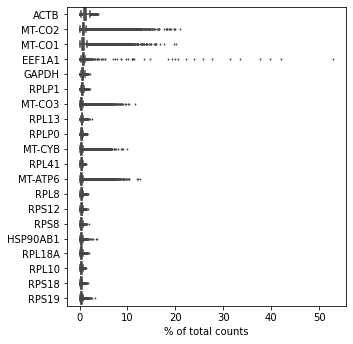

In [32]:
sc.pl.highest_expr_genes(adata, n_top=20, )

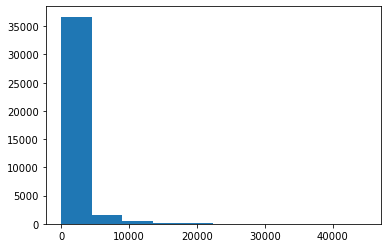

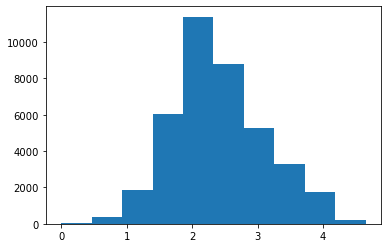

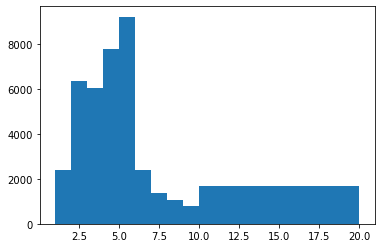

In [33]:
#sgRNA statistics and distribution
plt.hist(sgRNA['umis_sum'])
plt.show() 
plt.hist(np.log10(sgRNA['umis_sum']))
plt.show() 
bins_list = [1, 2, 3, 4, 5, 6, 7,8,9,10,20]
plt.hist(sgRNA['num_features'],bins = bins_list)
plt.show() 

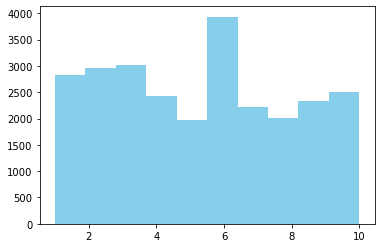

In [34]:
#cell number in each chromHMM statistics and distribution
plt.hist(sgRNA_with_all_cellular_BC_with_gene_name_chromHMM['ChromHMM'],color = "skyblue")
plt.show() 

Text(0.5, 1.0, 'sgRNA_gene_identity')

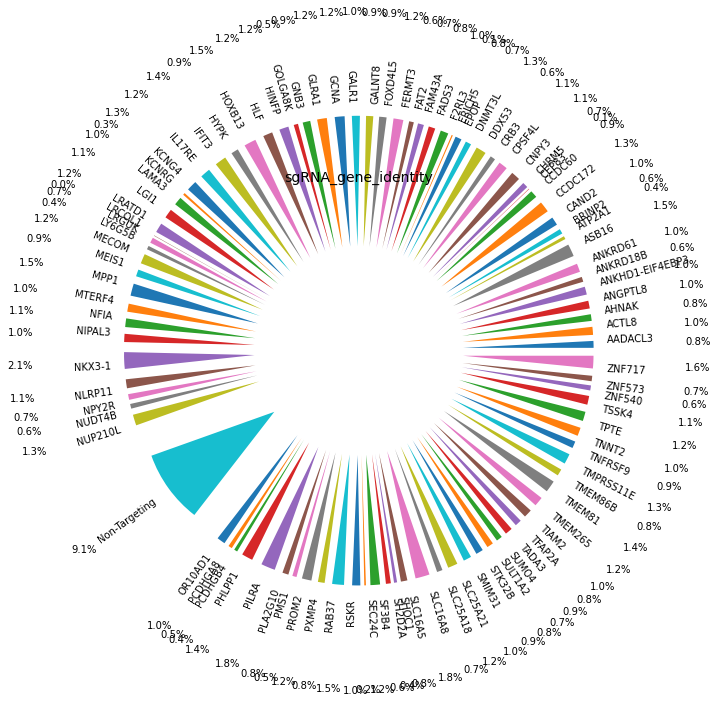

In [35]:
#for each of the CRISPR perturbtation statistics
#groupby the data by sgRNA identity

#Count the non-sgRNA labeled cells as seperate class 
#sgRNA_with_all_cellular_BC_with_gene_name_chromHMM["sgRNA_gene_identity"].fillna("no_sgRNA", inplace=True)
#sgRNA_with_all_cellular_BC_with_gene_name_chromHMM.head()

#Not count the non-sgRNA labeled cells as seperate class 
data = sgRNA_with_all_cellular_BC_with_gene_name_chromHMM.groupby("sgRNA_gene_identity").size()
pie, ax = plt.subplots(figsize=[10,6])
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", explode=[0.8]*97, labels=labels, pctdistance= 1.8,rotatelabels=True)
plt.title("sgRNA_gene_identity", fontsize=14)

In [36]:
#Use scrublet to remove the doublet
#For this step, we would need the expected doublet formation rate. These values can be found here. Since our dataset has approximately 10,000 (recovered) cells, we take the highest value given in the table. (https://uofuhealth.utah.edu/huntsman/shared-resources/gba/htg/single-cell/genomics-10x.php)
scrub = scr.Scrublet(adata.X, expected_doublet_rate = 0.076)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_counts=2, min_cells=3, 
                                                          min_gene_variability_pctl=85, n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.20
Detected doublet rate = 10.5%
Estimated detectable doublet fraction = 34.4%
Overall doublet rate:
	Expected   = 7.6%
	Estimated  = 30.7%
Elapsed time: 181.6 seconds


In [37]:
scrub.call_doublets(threshold=0.35)

Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 1.2%
Overall doublet rate:
	Expected   = 7.6%
	Estimated  = 13.8%


array([False, False, False, ..., False, False, False])

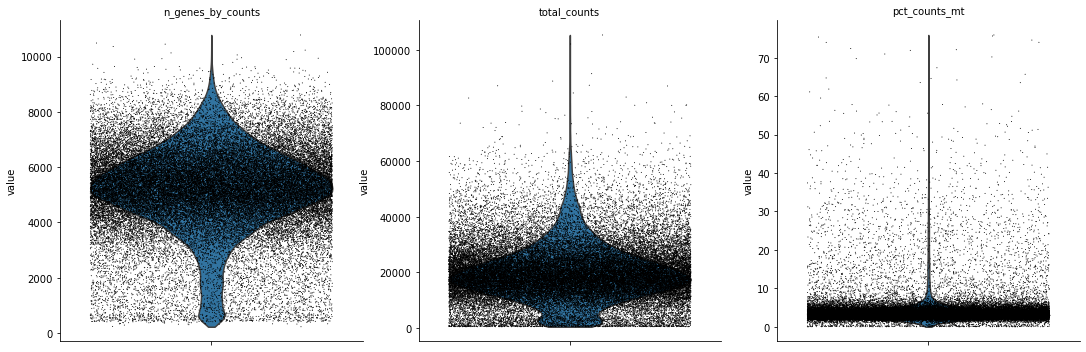

In [38]:
# adata basic QC
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

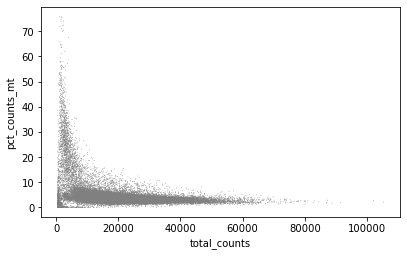

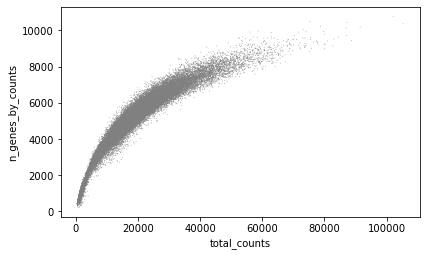

In [39]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [40]:
# Actually do the MT filtering by slicing the AnnData object. 
adata = adata[adata.obs.pct_counts_mt < 10, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [41]:
# normalize the the cell count to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)

#Logarithmize the data log(x+1)
sc.pp.log1p(adata)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


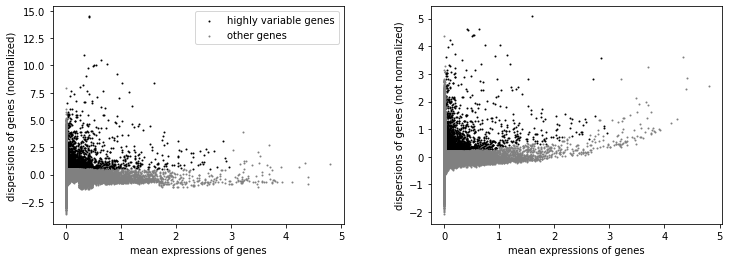

In [42]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression 
for later use in differential testing and visualizations of gene expression. 

This simply freezes the state of the AnnData object.

You can get back an AnnData of the object in .raw by calling .raw.to_adata().

In [43]:
print(list(adata.obs["sgRNA_gene_identity"].unique()))

['HINFP', 'nan', 'TNFRSF9', 'TMPRSS11E', 'PHLPP1', 'MPP1', 'SF3B4', 'TADA3', 'EPOP', 'SMIM31', 'ANKHD1-EIF4EBP3', 'GALR1', 'HLF', 'MECOM', 'Non-Targeting', 'GLRA1', 'PCDHGA8', 'HOXB13', 'MTERF4', 'DDX53', 'F2RL3', 'CPSF4L', 'TMEM86B', 'IL17RE', 'SUMO4', 'ANGPTL8', 'FADS3', 'TNNT2', 'STK32B', 'RAB37', 'CAND2', 'LAMA3', 'GCNA', 'NKX3-1', 'CCDC172', 'NFIA', 'LRATD1', 'NUDT4B', 'LY6G5B', 'PILRA', 'RSKR', 'PROM2', 'SULT1A2', 'GALNT8', 'TSSK4', 'MEIS1', 'GNB3', 'ZNF573', 'CNPY3', 'SH2D2A', 'DNMT3L', 'FAM43A', 'ANKRD61', 'SLC25A21', 'BRINP2', 'TIAM2', 'NIPAL3', 'HYPK', 'KCNG4', 'SLC16A8', 'NUP210L', 'TFAP2A', 'TMEM265', 'LRGUK', 'SLC16A5', 'TMEM81', 'PLA2G10', 'CHRM5', 'PMS1', 'FERMT3', 'NLRP11', 'PXMP4', 'AADACL3', 'CCDC60', 'ZNF717', 'ASB16', 'FAT2', 'TPTE', 'SHOC1', 'OR10AD1', 'ACTL8', 'SLC25A18', 'IFIT3', 'ANKRD18B', 'ZNF540', 'CRB3', 'LGI1', 'NPY2R', 'FOXD4L5', 'ATP2A1', 'GOLGA8K', 'AHNAK', 'KCNRG', 'ERICH5', 'PCDHGB4', 'SEC24C', 'LRCOL1', 'CEP83']


In [44]:
# slice the genes with enough sgRNA and put UMAP with Non-targeting and nan cells
def generate_umap_with_sliced_adata(gene_name_list,adata_name,marker_gene_list,PCA_comps_no):
    sliced_adata = adata_name[adata_name.obs["sgRNA_gene_identity"].isin(gene_name_list)]
    sc.pp.highly_variable_genes(sliced_adata)
    sc.pp.pca(sliced_adata, n_comps = PCA_comps_no, svd_solver = 'arpack')
    #use_highly_variable = True,
    sc.pp.neighbors(sliced_adata)
    sc.tl.umap(sliced_adata, random_state = 1)
    sc.pl.umap(sliced_adata, color = ['sgRNA_gene_identity'])
    sc.pl.umap(sliced_adata, color = gene_name_list[0:-1], color_map = 'RdPu')
    
    sc.tl.leiden(sliced_adata,resolution = 0.2)
    sc.pl.umap(sliced_adata, color= marker_gene_list)
    sc.tl.rank_genes_groups(sliced_adata, 'leiden', method='t-test')
    sc.pl.rank_genes_groups(sliced_adata, n_genes=40, sharey=False)
    

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


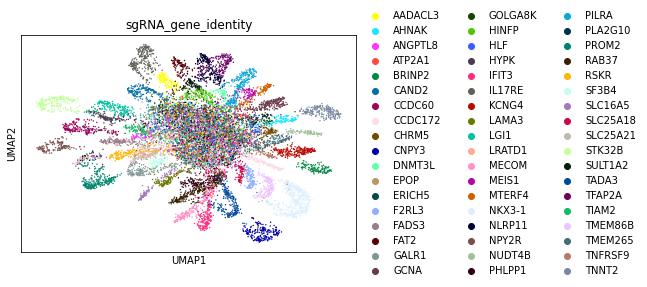

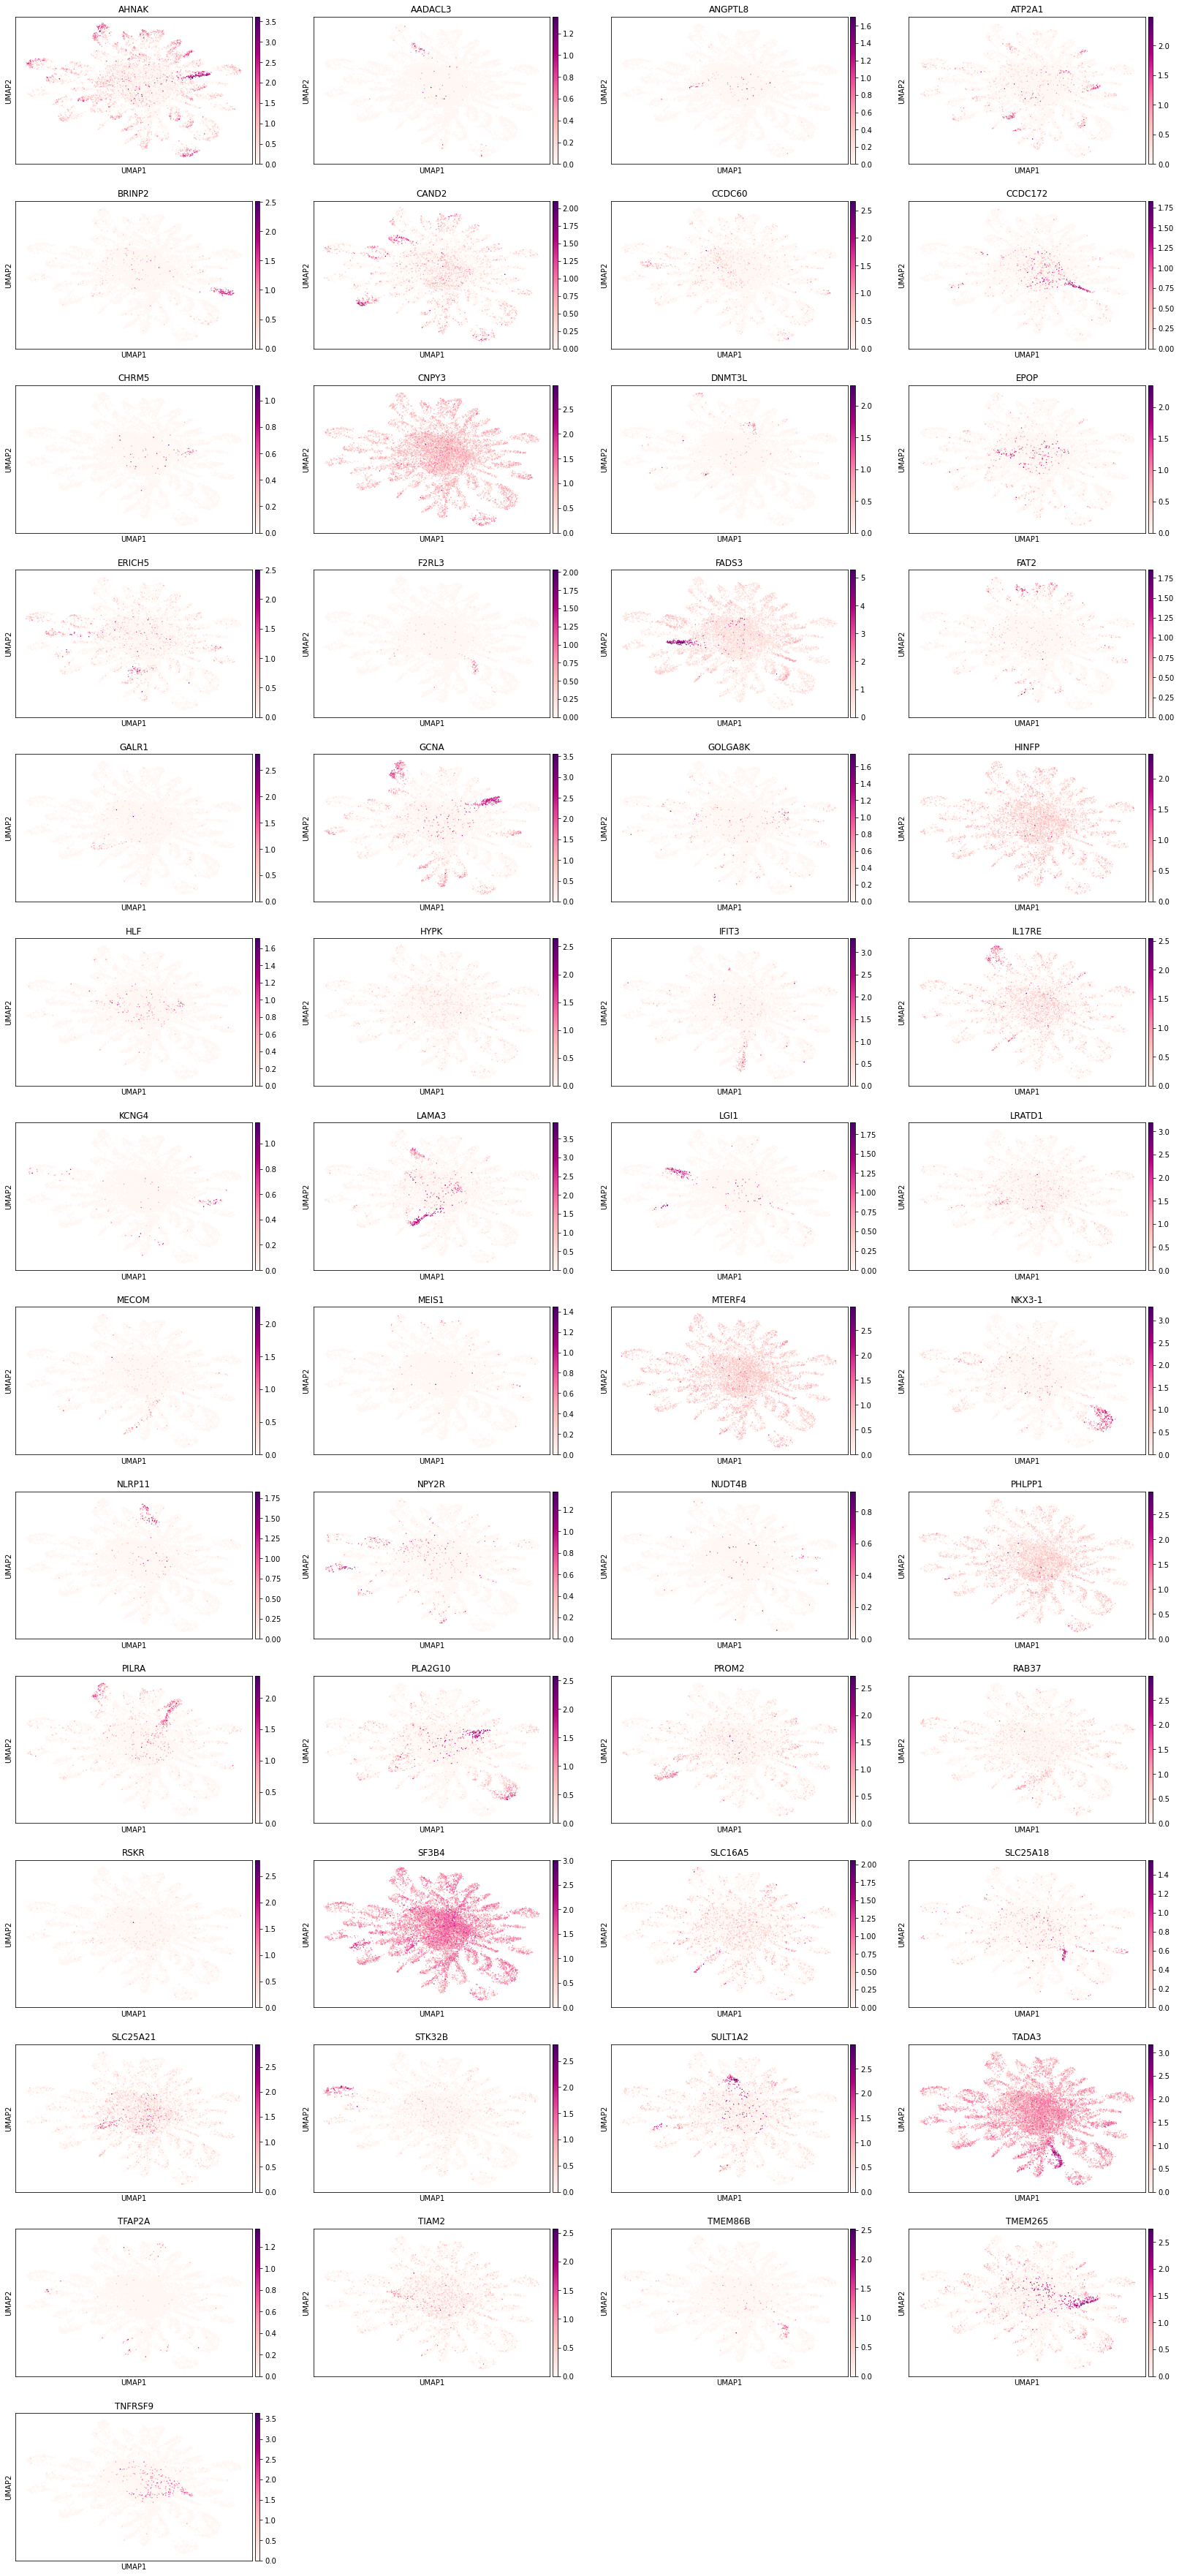

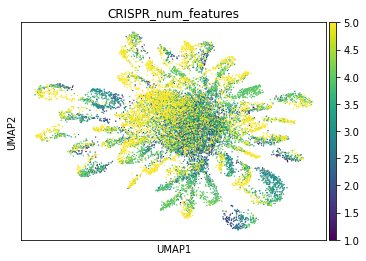

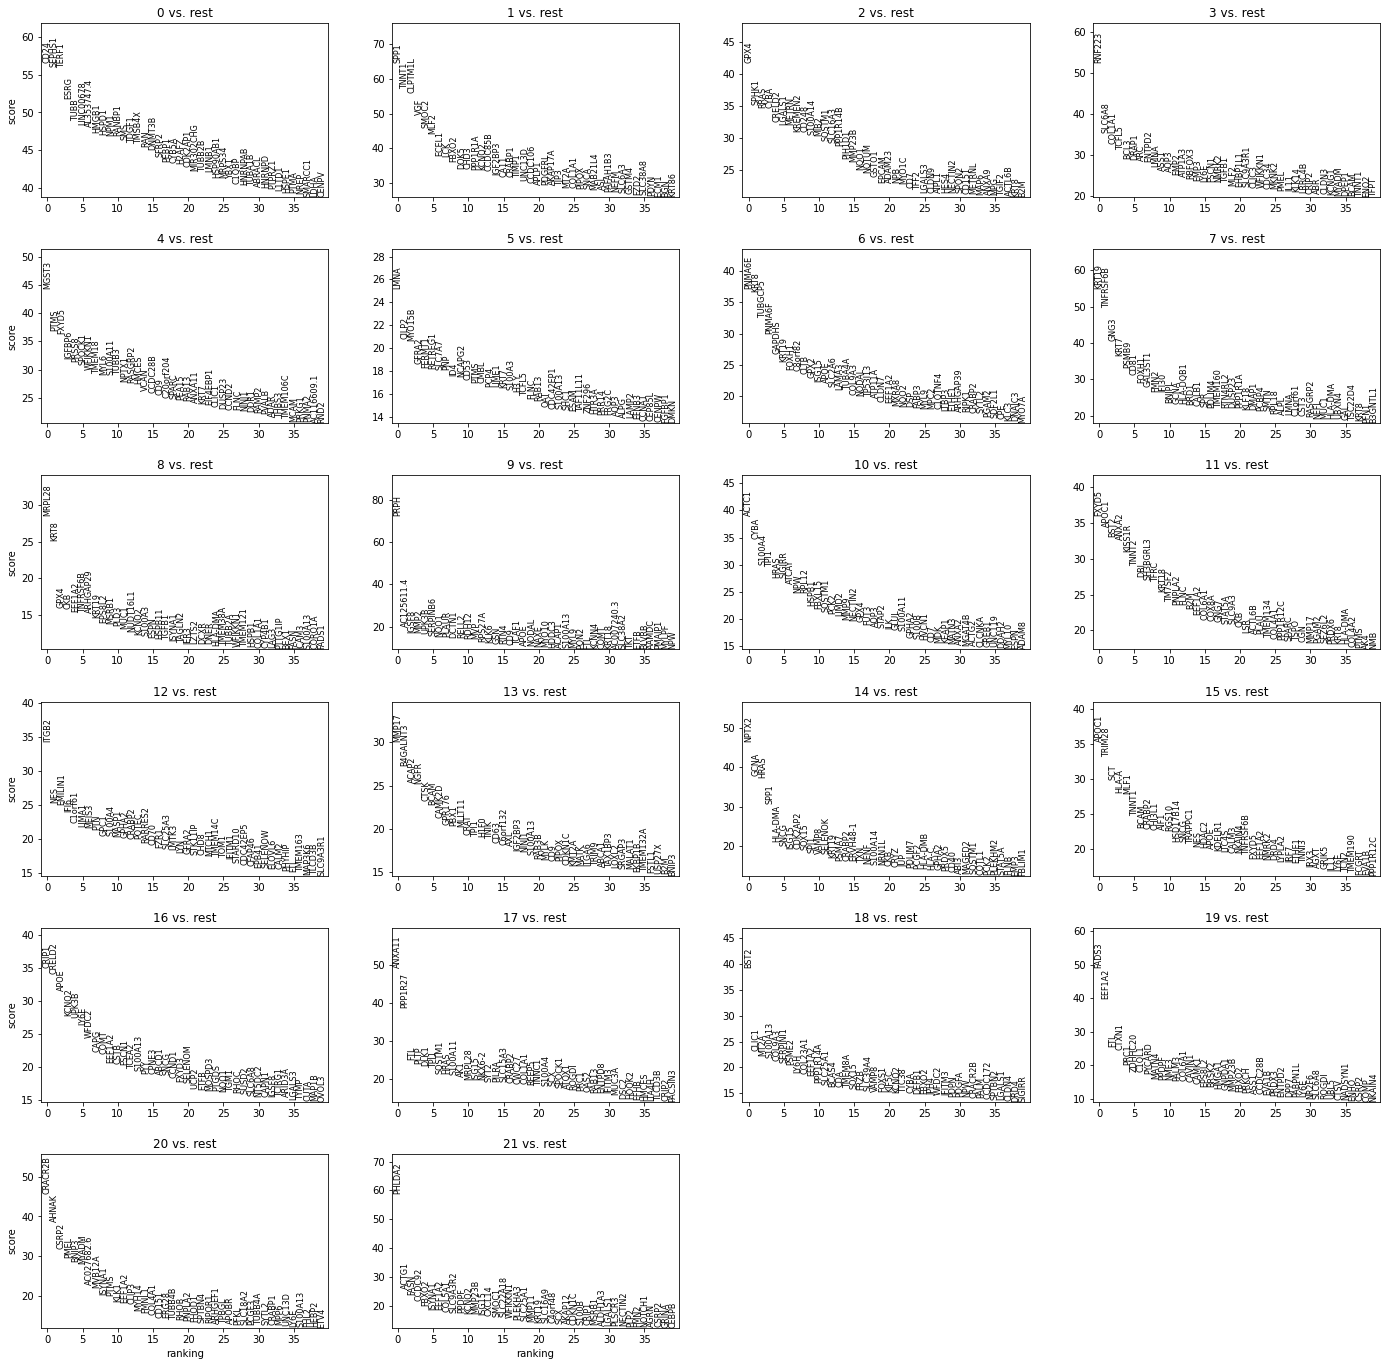

In [45]:
Phenotype_with_activation = ['AHNAK','AADACL3','ANGPTL8',
                            'ATP2A1','BRINP2','CAND2','CCDC60',
                            'CCDC172','CHRM5','CNPY3','CPSF4L',
                            'DNMT3L','EPOP','ERICH5','F2RL3',
                            'FADS3','FAT2','GALR1','GCNA',
                            'GOLGA8K','HINFP','HLF','HYPK',
                            'IFIT3','IL17RE','KCNG4',
                            'LAMA3','LGI1','LRATD1','LRGUK',
                            'LY6G5B','MECOM','MEIS1','MTERF4',
                            'NKX3-1','NLRP11','NPY2R','NUDT4B',
                            'NUP210L','PHLPP1','PILRA','PMS1',
                            'PLA2G10','PROM2','RAB37','RSKR',
                            'SF3B4','SLC16A5','SLC25A18','SLC25A21',
                            'STK32B','SULT1A2','SUMO4','TADA3',
                            'TFAP2A','TIAM2','TMEM81','TMEM86B',
                            'TMEM265','TNFRSF9','TNNT2','TSSK4',
                            'ZNF540','ZNF717']

Phenotype_no_activation = ['ASB16','CPSF4L','LRGUK','LY6G5B',
                          'NUP210L','SHOC1','PMS1',
                          'SUMO4','TMEM81','TSSK4',
                          'ZNF540','ZNF717','Non-Targeting']

#Phenotype_no_activation - Phenotype_no_activation
l3 = [x for x in Phenotype_with_activation if x not in Phenotype_no_activation]

generate_umap_with_sliced_adata(l3,adata,['CRISPR_num_features'],500)

In [46]:
# calculate for each sgRNA how many cells have the sgRNA identity
# plot distribution 
# filter out the small number sgRNA groups
pd.set_option('display.max_rows', None)

sgRNA_no_cell_distribution = pd.DataFrame(adata.obs.groupby(["ChromHMM","sgRNA_gene_identity"]).size().to_frame('size').reset_index())
sgRNA_no_cell_distribution = sgRNA_no_cell_distribution[sgRNA_no_cell_distribution['size'] > 0].reset_index(drop=True)
sgRNA_no_cell_distribution.head(10)

ChromHMM sgRNA_gene_identity  size
0       1.0               ASB16   434
1       1.0             CCDC172   380
2       1.0              CPSF4L   316
3       1.0              DNMT3L   199
4       1.0              IL17RE   357
5       1.0               KCNRG    77
6       1.0                LGI1   308
7       1.0                NFIA   305
8       1.0           TMPRSS11E   365
9       2.0             AADACL3   227

In [47]:
sgRNA_no_cell_distribution.shape

(95, 3)

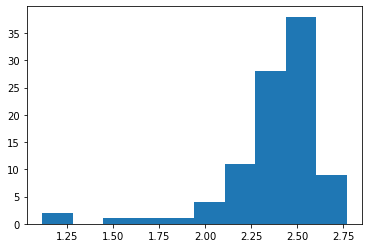

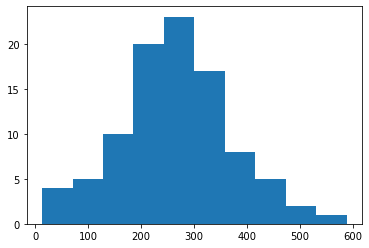

In [48]:
plt.hist(np.log10(sgRNA_no_cell_distribution['size']))
plt.show() 

plt.hist(sgRNA_no_cell_distribution['size'])
plt.show() 

In [49]:
sgRNA_no_cell_distribution.head()

ChromHMM sgRNA_gene_identity  size
0       1.0               ASB16   434
1       1.0             CCDC172   380
2       1.0              CPSF4L   316
3       1.0              DNMT3L   199
4       1.0              IL17RE   357

In [50]:
# filter out all the cells which sgRNA total counted cell is less than 40
sgRNA_no_cell_distribution[sgRNA_no_cell_distribution["size"] < 40]

ChromHMM sgRNA_gene_identity  size
38       5.0               CEP83    15
63       7.0              LRCOL1    13

In [51]:
# create marker gene dictionary
sgRNA_no_cell_distribution = sgRNA_no_cell_distribution[~sgRNA_no_cell_distribution['sgRNA_gene_identity'].isin(['ANKHD1-EIF4EBP3','CEP83','LRCOL1','Non-Targeting','nan'])]
marker_Gene_ChromHMM_dic = sgRNA_no_cell_distribution.groupby('ChromHMM')['sgRNA_gene_identity'].apply(list).to_dict()
keys_values = marker_Gene_ChromHMM_dic.items()
marker_Gene_ChromHMM_dic = {str(key): value for key, value in keys_values}

In [52]:
marker_Gene_ChromHMM_dic

{'1.0': ['ASB16',
  'CCDC172',
  'CPSF4L',
  'DNMT3L',
  'IL17RE',
  'KCNRG',
  'LGI1',
  'NFIA',
  'TMPRSS11E'],
 '2.0': ['AADACL3',
  'GALNT8',
  'IFIT3',
  'MPP1',
  'PROM2',
  'SLC16A8',
  'SLC25A18',
  'SULT1A2',
  'TNNT2'],
 '3.0': ['AHNAK',
  'F2RL3',
  'FERMT3',
  'GCNA',
  'GNB3',
  'HYPK',
  'NUP210L',
  'PILRA',
  'TMEM265'],
 '4.0': ['CNPY3',
  'PHLPP1',
  'PMS1',
  'SEC24C',
  'SF3B4',
  'SLC16A5',
  'SLC25A21',
  'TADA3'],
 '5.0': ['ATP2A1',
  'CAND2',
  'CRB3',
  'FADS3',
  'HINFP',
  'LRGUK',
  'MTERF4',
  'NIPAL3'],
 '6.0': ['BRINP2',
  'EPOP',
  'ERICH5',
  'FAM43A',
  'GALR1',
  'HLF',
  'HOXB13',
  'LAMA3',
  'MECOM',
  'MEIS1',
  'NKX3-1',
  'NPY2R',
  'STK32B',
  'TFAP2A'],
 '7.0': ['CCDC60',
  'FAT2',
  'FOXD4L5',
  'GLRA1',
  'OR10AD1',
  'RAB37',
  'SH2D2A',
  'TNFRSF9'],
 '8.0': ['ANKRD18B',
  'CHRM5',
  'DDX53',
  'GOLGA8K',
  'KCNG4',
  'NUDT4B',
  'PLA2G10',
  'PXMP4',
  'SHOC1'],
 '9.0': ['ACTL8',
  'NLRP11',
  'PCDHGA8',
  'PCDHGB4',
  'SMIM31',
  'TPTE',

In [53]:
group_order = ['ASB16', 'CCDC172', 'CPSF4L', 'DNMT3L', 'IL17RE', 'KCNRG', 'LGI1', 'NFIA', 'TMPRSS11E',
         'AADACL3', 'GALNT8', 'IFIT3', 'MPP1', 'PROM2', 'SLC16A8', 'SLC25A18', 'SULT1A2', 'TNNT2', 
         'AHNAK', 'F2RL3', 'FERMT3', 'GCNA', 'GNB3', 'HYPK', 'NUP210L', 'PILRA', 'TMEM265', 
         'CNPY3', 'PHLPP1', 'PMS1', 'SEC24C', 'SF3B4', 'SLC16A5', 'SLC25A21', 'TADA3', 
         'ATP2A1', 'CAND2', 'CRB3', 'FADS3', 'HINFP', 'LRGUK', 'MTERF4', 'NIPAL3', 
         'BRINP2', 'EPOP', 'ERICH5', 'FAM43A', 'GALR1', 'HLF', 'HOXB13', 'LAMA3', 'MECOM', 'MEIS1', 'NKX3-1', 'NPY2R', 'STK32B', 'TFAP2A', 
         'CCDC60', 'FAT2', 'FOXD4L5', 'GLRA1', 'OR10AD1', 'RAB37', 'SH2D2A', 'TNFRSF9', 
         'ANKRD18B', 'CHRM5', 'DDX53', 'GOLGA8K', 'KCNG4', 'NUDT4B', 'PLA2G10', 'PXMP4', 'SHOC1', 
         'ACTL8', 'NLRP11', 'PCDHGA8', 'PCDHGB4', 'SMIM31', 'TPTE', 'ZNF540', 'ZNF573', 'ZNF717', 
         'ANGPTL8', 'ANKRD61', 'LY6G5B', 'RSKR', 'SUMO4', 'TIAM2', 'TMEM81', 'TMEM86B', 'TSSK4',
         'ANKHD1-EIF4EBP3','CEP83','LRCOL1','Non-Targeting','LRATD1','nan']

adata.obs['sgRNA_gene_identity'] = (adata.obs['sgRNA_gene_identity'].astype('category')).cat.reorder_categories(list(group_order), ordered=True)


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


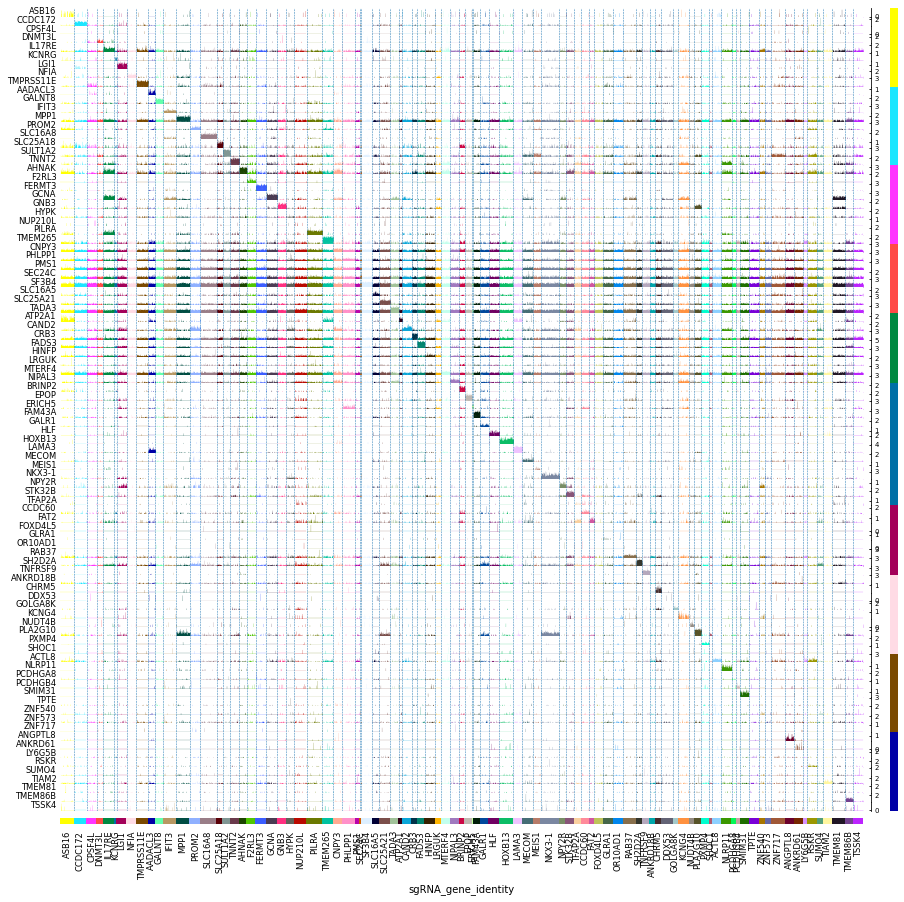

In [54]:
sc.pl.tracksplot(adata[adata.obs["sgRNA_gene_identity"].isin(sgRNA_no_cell_distribution["sgRNA_gene_identity"])], 
                 marker_Gene_ChromHMM_dic, groupby='sgRNA_gene_identity',figsize = (15,15))

Trying to set attribute `.uns` of view, copying.


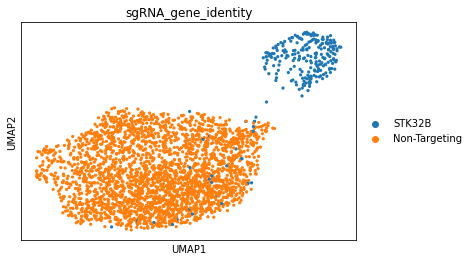

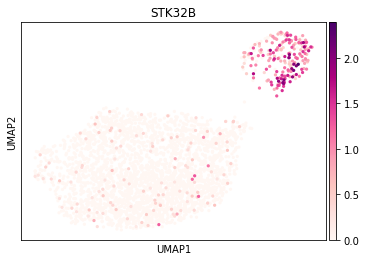

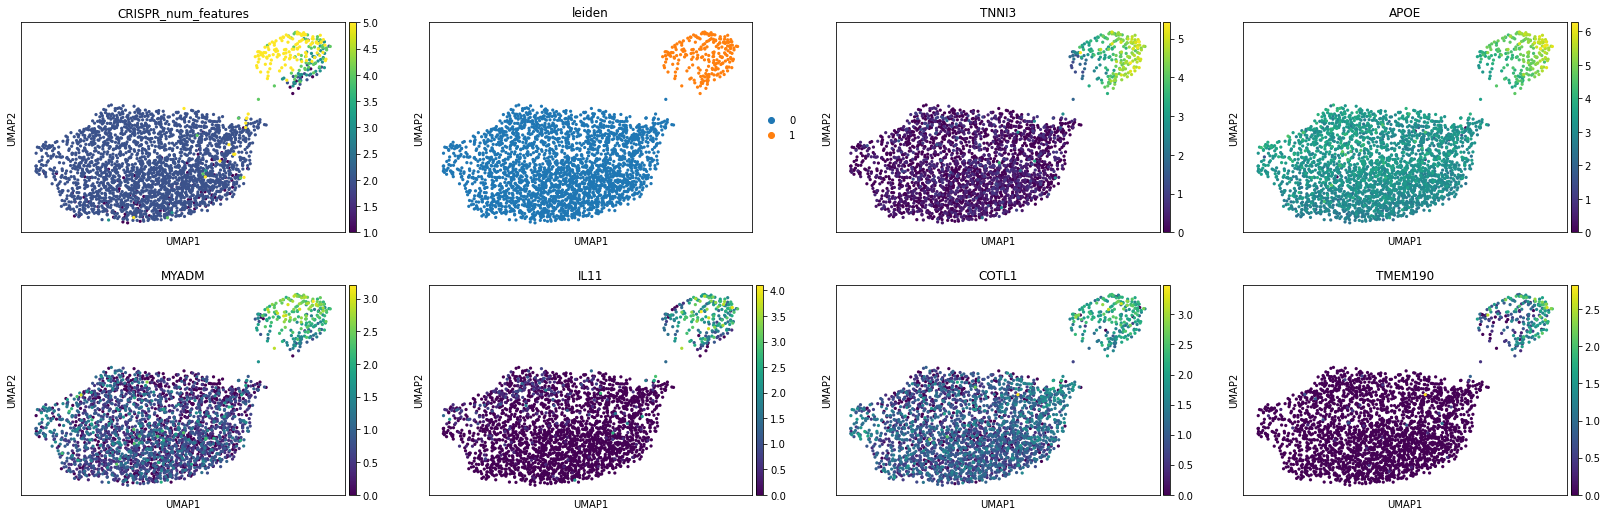

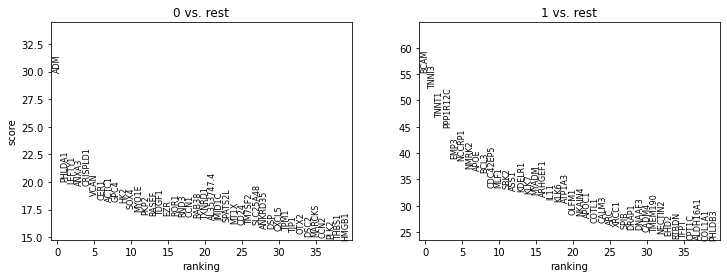

In [55]:
generate_umap_with_sliced_adata(['STK32B','Non-Targeting'],adata,['CRISPR_num_features','leiden','TNNI3','APOE','MYADM','IL11','COTL1','TMEM190'],500)
#TNNI3 as cardimyocyte fibroblast
#APOE as regulator for HSC
#MYADM, a novel hematopoietic-associated marker gene 
#Interleukin-11 stimulates the proliferation of human hematopoietic CD34+ and CD34+CD33-DR- cells 
#COTL1 gene or protein that maintains and regulates the homeostasis of hematopoietic stem cells.
#TMEM190 Hematopoietic progenitor cell differentiation.

In [58]:
# slice the genes with enough sgRNA and put UMAP with Non-targeting and nan cells
def generate_cluster_file_with_sliced_adata(gene_name_list,adata_name,PCA_comps_no):
    sliced_adata = adata_name[adata_name.obs["sgRNA_gene_identity"].isin(gene_name_list)]
    sliced_cellular_BC = pd.DataFrame(sliced_adata.obs)
    sliced_cellular_BC.to_csv('{}.csv'.format(gene_name_list))  
#    print(sliced_cellular_BC['sgRNA_gene_identity'])
    
generate_cluster_file_with_sliced_adata(['Non-Targeting'],adata,500)

In [57]:
# generate a dataframe which contain all the acivated data and control data, 
# cell barcode and total count (this is for CQ to use the original count for single cell activation)
# slice the anndata with particular sgRNA combination

def duplicate(testList, n):
    return [ele for ele in testList for _ in range(n)]

def sub_anndata(anndata,CRISPR_sgRNA_feature):
    df = anndata[anndata.obs["sgRNA_gene_identity"] == CRISPR_sgRNA_feature]
    return df

def sub_anndata_total_count(anndata,CRISPR_sgRNA_feature):
    df = anndata[anndata.obs["sgRNA_gene_identity"] == CRISPR_sgRNA_feature]
    return df.obs['n_count'].reset_index()['n_count']

def sub_anndata_cell_barcode(anndata,CRISPR_sgRNA_feature):
    df = anndata[anndata.obs["sgRNA_gene_identity"] == CRISPR_sgRNA_feature]
    return df.obs['n_count'].reset_index()['index']

def generate_gene_count_list(CRISPR_sgRNA_feature,adata):
    df = pd.DataFrame(columns=['Gene_name','Class','value','n_count','cell_barcode'])
    a = sub_anndata(adata,CRISPR_sgRNA_feature)[:, adata.var_names.str.match(CRISPR_sgRNA_feature)]
    b = sub_anndata(adata,"Non-Targeting")[:, adata.var_names.str.match(CRISPR_sgRNA_feature)]
    
    if len(pd.DataFrame(a.X.todense()).sum()/pd.DataFrame(a.X.todense()).shape[0]) == 1:
        value_CRISPRa = pd.DataFrame(a.X.todense(),columns=['value'])
        value_CRISPRa['Gene_name'] = CRISPR_sgRNA_feature
        value_CRISPRa['Class'] = 'CRISPRa'
        value_CRISPRa['n_count']= sub_anndata_total_count(adata,CRISPR_sgRNA_feature)
        value_CRISPRa['cell_barcode']= sub_anndata_cell_barcode(adata,CRISPR_sgRNA_feature)
        df = df.append(value_CRISPRa)
    
        value_control = pd.DataFrame(b.X.todense(),columns=['value'])
        value_control['Gene_name'] = CRISPR_sgRNA_feature
        value_control['Class'] = 'control'
        value_control['n_count']= sub_anndata_total_count(adata,"Non-Targeting")
        value_control['cell_barcode']= sub_anndata_cell_barcode(adata,"Non-Targeting")
        df = df.append(value_control)
    
    if len(pd.DataFrame(a.X.todense()).sum()/pd.DataFrame(a.X.todense()).shape[0]) > 1:
        dup = len(pd.DataFrame(a.X.todense()).sum()/pd.DataFrame(a.X.todense()).shape[0])
        value_CRISPRa = pd.DataFrame(pd.DataFrame(a.X.todense()).stack().reset_index()[0])
        value_CRISPRa.columns =['value']
        value_CRISPRa['Gene_name'] = CRISPR_sgRNA_feature
        value_CRISPRa['Class'] = 'CRISPRa'
        value_CRISPRa['n_count']= duplicate(sub_anndata_total_count(adata,CRISPR_sgRNA_feature),dup)
        value_CRISPRa['cell_barcode']= duplicate(sub_anndata_cell_barcode(adata,CRISPR_sgRNA_feature),dup)
        df = df.append(value_CRISPRa)
        
        value_control = pd.DataFrame(pd.DataFrame(b.X.todense()).stack().reset_index()[0])
        value_control.columns =['value']
        value_control['Gene_name'] = CRISPR_sgRNA_feature
        value_control['Class'] = 'control'
        value_control['n_count']= duplicate(sub_anndata_total_count(adata,"Non-Targeting"),dup)
        value_control['cell_barcode']= duplicate(sub_anndata_cell_barcode(adata,"Non-Targeting"),dup)
        df = df.append(value_control)
        
    print(df.shape)    
    return df
    

CRISPR_activation_data = pd.DataFrame(columns=['Gene_name','Class','value'])

for i in list(sgRNA_no_cell_distribution["sgRNA_gene_identity"]):
    print(i)
    CRISPR_activation_data = CRISPR_activation_data.append(generate_gene_count_list(i,adata))

ASB16
(6102, 5)
CCDC172
(2997, 5)
CPSF4L
(2933, 5)
DNMT3L
(2816, 5)
IL17RE
(5948, 5)
KCNRG
(2694, 5)
LGI1
(2925, 5)
NFIA
(8766, 5)
TMPRSS11E
(2982, 5)
AADACL3
(2844, 5)
GALNT8
(2869, 5)
IFIT3
(3015, 5)
MPP1
(3043, 5)
PROM2
(2948, 5)
SLC16A8
(3121, 5)
SLC25A18
(2811, 5)
SULT1A2
(2845, 5)
TNNT2
(2904, 5)
AHNAK
(5700, 5)
F2RL3
(2896, 5)
FERMT3
(2958, 5)
GCNA
(2961, 5)
GNB3
(2888, 5)
HYPK
(2871, 5)
NUP210L
(2999, 5)
PILRA
(3116, 5)
TMEM265
(2948, 5)
CNPY3
(2907, 5)
PHLPP1
(3012, 5)
PMS1
(2763, 5)
SEC24C
(2674, 5)
SF3B4
(2952, 5)
SLC16A5
(2840, 5)
SLC25A21
(5922, 5)
TADA3
(2878, 5)
ATP2A1
(5448, 5)
CAND2
(2912, 5)
CRB3
(2792, 5)
FADS3
(2852, 5)
HINFP
(2942, 5)
LRGUK
(2803, 5)
MTERF4
(2897, 5)
NIPAL3
(2907, 5)
BRINP2
(2787, 5)
EPOP
(2844, 5)
ERICH5
(2657, 5)
FAM43A
(2828, 5)
GALR1
(2888, 5)
HLF
(2953, 5)
HOXB13
(3049, 5)
LAMA3
(2899, 5)
MECOM
(2950, 5)
MEIS1
(8577, 5)
NKX3-1
(3205, 5)
NPY2R
(2813, 5)
STK32B
(2872, 5)
TFAP2A
(8532, 5)
CCDC60
(2872, 5)
FAT2
(2780, 5)
FOXD4L5
(2874, 5)
GLRA1
(2

In [59]:
CRISPR_activation_data.shape

(300609, 5)

In [60]:
CRISPR_activation_data.head(5)

Gene_name    Class     value  n_count        cell_barcode
0     ASB16  CRISPRa  0.000000  22379.0  AAAGTAGCAATACGCT-1
1     ASB16  CRISPRa  0.000000  22379.0  AAAGTAGCAATACGCT-1
2     ASB16  CRISPRa  0.000000  26002.0  AAATGCCTCTGCCAGG-1
3     ASB16  CRISPRa  0.325401  26002.0  AAATGCCTCTGCCAGG-1
4     ASB16  CRISPRa  0.000000  14895.0  AACCGCGCACCTCGGA-1

In [61]:
df = CRISPR_activation_data[['Gene_name','Class','value']].groupby(['Gene_name','Class']).agg(lambda x: x.eq(0).sum()).reset_index()
df = df.rename(columns={'value': 'zero_count'})
df.head()

Gene_name    Class  zero_count
0   AADACL3  CRISPRa       151.0
1   AADACL3  control      2616.0
2     ACTL8  CRISPRa        95.0
3     ACTL8  control      2425.0
4     AHNAK  CRISPRa       131.0

In [62]:
df2 = CRISPR_activation_data.groupby(['Gene_name','Class']).count().reset_index()
df2 = df2[['Gene_name','Class','value']]
df2 = df2.rename(columns={'value': 'all_count'})
df2.head()

Gene_name    Class  all_count
0   AADACL3  CRISPRa        227
1   AADACL3  control       2617
2     ACTL8  CRISPRa        285
3     ACTL8  control       2617
4     AHNAK  CRISPRa        466

In [63]:
Zero_stats = pd.merge(df, df2, on=["Gene_name","Class"])
Zero_stats.head()

Gene_name    Class  zero_count  all_count
0   AADACL3  CRISPRa       151.0        227
1   AADACL3  control      2616.0       2617
2     ACTL8  CRISPRa        95.0        285
3     ACTL8  control      2425.0       2617
4     AHNAK  CRISPRa       131.0        466

In [64]:
Zero_stats['zero_persentage'] = Zero_stats['zero_count'] / Zero_stats ['all_count']
Zero_stats['non_zero_persentage'] = 1-Zero_stats['zero_persentage']
Zero_stats.head()

Gene_name    Class  zero_count  all_count  zero_persentage  \
0   AADACL3  CRISPRa       151.0        227         0.665198   
1   AADACL3  control      2616.0       2617         0.999618   
2     ACTL8  CRISPRa        95.0        285         0.333333   
3     ACTL8  control      2425.0       2617         0.926634   
4     AHNAK  CRISPRa       131.0        466         0.281116   

   non_zero_persentage  
0             0.334802  
1             0.000382  
2             0.666667  
3             0.073366  
4             0.718884

In [65]:
# merge zero_stats with ChromHMM 
ChromHMM = gene_chromatin[['sgRNA_gene_identity','ChromHMM']]
ChromHMM = ChromHMM.rename(columns={'sgRNA_gene_identity': 'Gene_name'})
ChromHMM.head()

Gene_name  ChromHMM
0     DNMT3L         1
1     CPSF4L         1
2  TMPRSS11E         1
3       NFIA         1
4      KCNRG         1

In [66]:
Zero_stats_chrom = pd.merge(Zero_stats, ChromHMM, on=["Gene_name"])
Zero_stats_chrom.head()

Gene_name    Class  zero_count  all_count  zero_persentage  \
0   AADACL3  CRISPRa       151.0        227         0.665198   
1   AADACL3  control      2616.0       2617         0.999618   
2     ACTL8  CRISPRa        95.0        285         0.333333   
3     ACTL8  control      2425.0       2617         0.926634   
4     AHNAK  CRISPRa       131.0        466         0.281116   

   non_zero_persentage  ChromHMM  
0             0.334802         2  
1             0.000382         2  
2             0.666667         9  
3             0.073366         9  
4             0.718884         3

In [67]:
Zero_stats_chrom_sort = Zero_stats_chrom.sort_values(['zero_persentage', 'Gene_name'],
              ascending = [False, True])

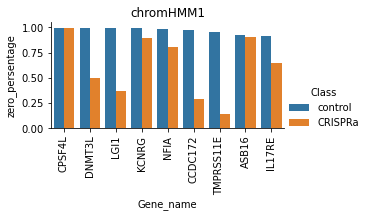

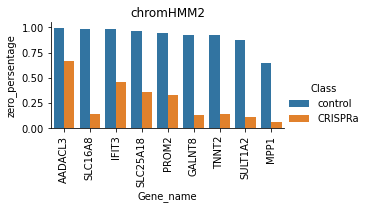

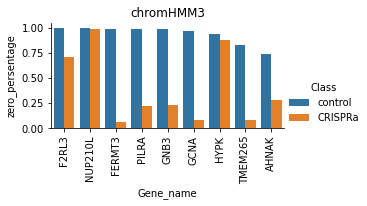

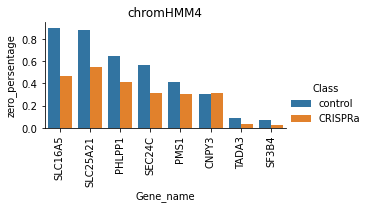

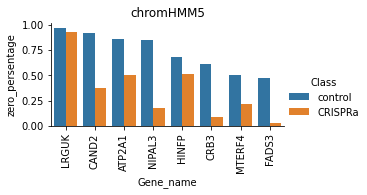

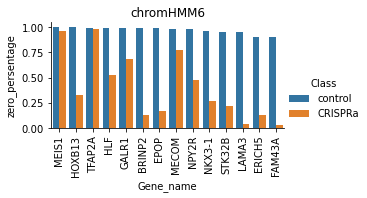

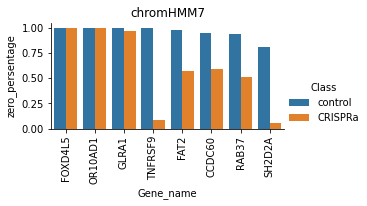

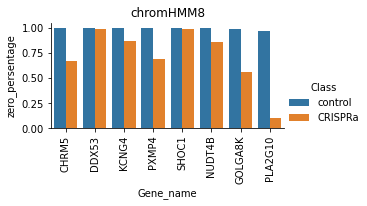

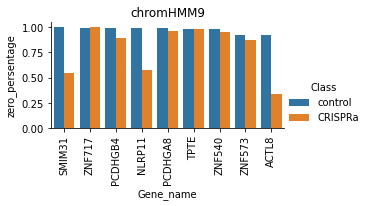

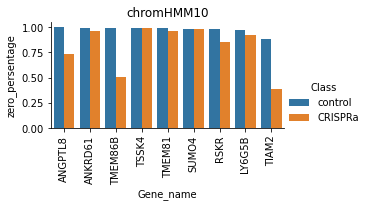

In [68]:
palette ={"control": "C0", "CRISPRa": "C1"}
hue_order = ['control', 'CRISPRa']
for i in range(1,11):
    current_df = Zero_stats_chrom_sort[Zero_stats_chrom_sort['ChromHMM']==i]
    ax = sns.catplot(
    data=current_df, kind="bar",
    x="Gene_name", y="zero_persentage", hue="Class",hue_order=hue_order,
    palette=palette, height=2, aspect=2)
    #ax.set_title('chromHMM' %i)
    plt.title("chromHMM"+ str(i))
    plt.xticks(rotation=90)
    plt.savefig('ChromHMM'+ str(i) + '_zero_stats.pdf')

In [69]:
Zero_stats_control = Zero_stats[Zero_stats['Class'].str.contains("control")]
Zero_stats_CRISPRa = Zero_stats[Zero_stats['Class'].str.contains("CRISPRa")]

In [70]:
Zero_stats_control['zero_persentage'].describe()

count    92.000000
mean      0.901889
std       0.186734
min       0.066488
25%       0.918943
50%       0.981849
75%       0.995892
max       1.000000
Name: zero_persentage, dtype: float64

In [71]:
Zero_stats_CRISPRa['zero_persentage'].describe()

count    92.000000
mean      0.525094
std       0.339205
min       0.028436
25%       0.219170
50%       0.510761
75%       0.881381
max       1.000000
Name: zero_persentage, dtype: float64

In [72]:
# merge the activation data with ChromHMM
gene_chromatin.columns = ['Gene_name','ChromHMM','Basal_count_bulk']
gene_chromatin.head()

Gene_name  ChromHMM  Basal_count_bulk
0     DNMT3L         1          5.000000
1     CPSF4L         1          5.333333
2  TMPRSS11E         1          5.333333
3       NFIA         1         25.666667
4      KCNRG         1         27.000000

In [73]:
CRISPR_activation_data_chromHMM = pd.merge(CRISPR_activation_data, 
                                           gene_chromatin, how="left", on=["Gene_name"])
CRISPR_activation_data_chromHMM.head()

Gene_name    Class     value  n_count        cell_barcode  ChromHMM  \
0     ASB16  CRISPRa  0.000000  22379.0  AAAGTAGCAATACGCT-1       1.0   
1     ASB16  CRISPRa  0.000000  22379.0  AAAGTAGCAATACGCT-1       1.0   
2     ASB16  CRISPRa  0.000000  26002.0  AAATGCCTCTGCCAGG-1       1.0   
3     ASB16  CRISPRa  0.325401  26002.0  AAATGCCTCTGCCAGG-1       1.0   
4     ASB16  CRISPRa  0.000000  14895.0  AACCGCGCACCTCGGA-1       1.0   

   Basal_count_bulk  
0        232.333333  
1        232.333333  
2        232.333333  
3        232.333333  
4        232.333333

In [74]:
# create bin based on the single cell mean in control group
CRISPR_activation_data_chromHMM_control = CRISPR_activation_data_chromHMM.loc[CRISPR_activation_data_chromHMM['Class'] == "control"]
single_cell_basal = CRISPR_activation_data_chromHMM_control.groupby('Gene_name')['value'].mean().reset_index()
single_cell_basal.head()
single_cell_basal['binned'] = pd.qcut(single_cell_basal.value,5)
CRISPR_activation_data_chromHMM_merged = pd.merge(CRISPR_activation_data_chromHMM, 
                                                  single_cell_basal, how="left", on=["Gene_name"])
CRISPR_activation_data_chromHMM_merged['fold_change'] = CRISPR_activation_data_chromHMM_merged['value_x'] / (CRISPR_activation_data_chromHMM_merged ['Basal_count_bulk']+1)
CRISPR_activation_data_chromHMM_merged.head()

Gene_name    Class   value_x  n_count        cell_barcode  ChromHMM  \
0     ASB16  CRISPRa  0.000000  22379.0  AAAGTAGCAATACGCT-1       1.0   
1     ASB16  CRISPRa  0.000000  22379.0  AAAGTAGCAATACGCT-1       1.0   
2     ASB16  CRISPRa  0.000000  26002.0  AAATGCCTCTGCCAGG-1       1.0   
3     ASB16  CRISPRa  0.325401  26002.0  AAATGCCTCTGCCAGG-1       1.0   
4     ASB16  CRISPRa  0.000000  14895.0  AACCGCGCACCTCGGA-1       1.0   

   Basal_count_bulk   value_y            binned  fold_change  
0        232.333333  0.035112  (0.0174, 0.0528]     0.000000  
1        232.333333  0.035112  (0.0174, 0.0528]     0.000000  
2        232.333333  0.035112  (0.0174, 0.0528]     0.000000  
3        232.333333  0.035112  (0.0174, 0.0528]     0.001395  
4        232.333333  0.035112  (0.0174, 0.0528]     0.000000

In [75]:
# bin basal count bulk and look the control and CRISPRa value
bins = [0, 1, 5, 10, 25, 50, 100]
CRISPR_activation_data_chromHMM['binned'] = pd.qcut(CRISPR_activation_data_chromHMM.Basal_count_bulk,5)
CRISPR_activation_data_chromHMM.head()

Gene_name    Class     value  n_count        cell_barcode  ChromHMM  \
0     ASB16  CRISPRa  0.000000  22379.0  AAAGTAGCAATACGCT-1       1.0   
1     ASB16  CRISPRa  0.000000  22379.0  AAAGTAGCAATACGCT-1       1.0   
2     ASB16  CRISPRa  0.000000  26002.0  AAATGCCTCTGCCAGG-1       1.0   
3     ASB16  CRISPRa  0.325401  26002.0  AAATGCCTCTGCCAGG-1       1.0   
4     ASB16  CRISPRa  0.000000  14895.0  AACCGCGCACCTCGGA-1       1.0   

   Basal_count_bulk            binned  
0        232.333333  (132.667, 381.0]  
1        232.333333  (132.667, 381.0]  
2        232.333333  (132.667, 381.0]  
3        232.333333  (132.667, 381.0]  
4        232.333333  (132.667, 381.0]

In [76]:
CRISPR_activation_data_chromHMM['binned'].unique()

[(132.667, 381.0], (25.667, 132.667], (-0.001, 8.333], (8.333, 25.667], NaN, (381.0, 4371.0]]
Categories (5, interval[float64]): [(-0.001, 8.333] < (8.333, 25.667] < (25.667, 132.667] < (132.667, 381.0] < (381.0, 4371.0]]

In [77]:
CRISPR_activation_data_chromHMM = CRISPR_activation_data_chromHMM.sort_values(by=['binned'])
CRISPR_activation_data_chromHMM.head()

Gene_name    Class  value  n_count        cell_barcode  ChromHMM  \
249363    NLRP11  control    0.0   8142.0  ACTTGTTCATGCGCAC-1       9.0   
239395   PLA2G10  control    0.0   6953.0  GGCGACTCATACAGCT-1       8.0   
239396   PLA2G10  control    0.0  16710.0  GGCGTGTGTACCTACA-1       8.0   
239397   PLA2G10  control    0.0  13192.0  GGCGTGTTCATACGGT-1       8.0   
239398   PLA2G10  control    0.0  20419.0  GGCGTGTTCGAACTGT-1       8.0   

        Basal_count_bulk           binned  
249363          2.000000  (-0.001, 8.333]  
239395          1.666667  (-0.001, 8.333]  
239396          1.666667  (-0.001, 8.333]  
239397          1.666667  (-0.001, 8.333]  
239398          1.666667  (-0.001, 8.333]

In [78]:
# look CRISPRa value across all the genes expression
all_gene_list = adata.var['gene_ids'].head()

In [79]:
adata.var.head()

gene_ids    feature_types     mt  n_cells_by_counts  \
MIR1302-2HG  ENSG00000243485  Gene Expression  False                  8   
FAM138A      ENSG00000237613  Gene Expression  False                  0   
OR4F5        ENSG00000186092  Gene Expression  False                  0   
AL627309.1   ENSG00000238009  Gene Expression  False                108   
AL627309.3   ENSG00000239945  Gene Expression  False                  3   

             mean_counts  pct_dropout_by_counts  total_counts  \
MIR1302-2HG     0.000169              99.983113           8.0   
FAM138A         0.000000             100.000000           0.0   
OR4F5           0.000000             100.000000           0.0   
AL627309.1      0.002322              99.772032         110.0   
AL627309.3      0.000063              99.993668           3.0   

             highly_variable         means  dispersions  dispersions_norm  
MIR1302-2HG            False  8.153821e-05    -0.616078         -1.006721  
FAM138A                False  1.000000e-12          NaN          0.000000  
OR4F5                  False  1.000000e-12          NaN          0.000000  
AL627309.1             False  1.189365e-03    -0.394903         -0.610922  
AL627309.3             False  3.782067e-05    -0.564329         -0.914116

In [80]:
all_expression = pd.DataFrame(columns = ['value'])
all_expression['value'] = adata.var['mean_counts']
all_expression.head()

value
MIR1302-2HG  0.000169
FAM138A      0.000000
OR4F5        0.000000
AL627309.1   0.002322
AL627309.3   0.000063

In [81]:
# create a dataframe compare all gene distribution with activated CRISPRa distribution
all_expression = all_expression.reset_index()
all_expression = all_expression.drop("index",1)
all_expression['Gene_name'] = "all_gene"
all_expression['Class'] = "all_endo_gene"
all_expression['ChromHMM'] = "all"
all_expression.head()

value Gene_name          Class ChromHMM
0  0.000169  all_gene  all_endo_gene      all
1  0.000000  all_gene  all_endo_gene      all
2  0.000000  all_gene  all_endo_gene      all
3  0.002322  all_gene  all_endo_gene      all
4  0.000063  all_gene  all_endo_gene      all

In [82]:
all_expression_result = all_expression.append(CRISPR_activation_data_chromHMM[['Gene_name','Class',
                                                                               'ChromHMM','value']], ignore_index=True, sort=False)
all_expression_result.shape

(337213, 4)

In [83]:
all_expression_result=all_expression_result.sort_values(by=['value'])
all_expression_result.head()

value Gene_name    Class ChromHMM
168606    0.0     GALR1  control      6.0
207588    0.0     KCNRG  control      1.0
207587    0.0     KCNRG  control      1.0
207586    0.0     KCNRG  control      1.0
207585    0.0     KCNRG  control      1.0

In [84]:
test = all_expression_result.loc[all_expression_result["Class"] == "CRISPRa"]
test.tail()

value Gene_name    Class ChromHMM
282203  4.964714     FADS3  CRISPRa      5.0
282051  5.077460     FADS3  CRISPRa      5.0
281876  5.120483     FADS3  CRISPRa      5.0
281899  5.192517     FADS3  CRISPRa      5.0
282021  5.285567     FADS3  CRISPRa      5.0

In [86]:
my_order = test.groupby(by=["Gene_name"])["value"].median().iloc[::-1].reset_index()
my_order = my_order.sort_values(by=['value'])['Gene_name']
#my_order = my_order.remove('all_gene')
#print(my_order)

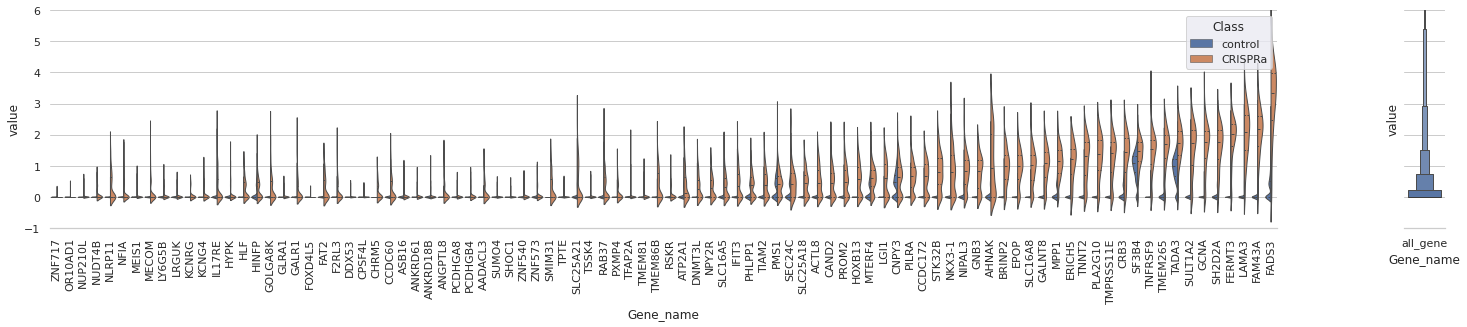

In [87]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested violinplot and split the violins for easier comparison
f, axs = plt.subplots(1,2,
                      figsize=(25,4),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[3,0.1]))

sns.set(rc={'figure.figsize':(25,4)})
ax = sns.violinplot(data=all_expression_result.loc[all_expression_result["Gene_name"] != "all_gene"], x="Gene_name", 
                    order = my_order,
                    y="value", hue="Class",split=True,
               inner="quart", linewidth=1, scale="width",ax=axs[0])
sns.despine(left=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

ax1 = sns.boxenplot(data=all_expression_result.loc[all_expression_result["Gene_name"] == "all_gene"], x="Gene_name", y="value",
               linewidth=1, ax=axs[1]) #inner="quart", scale="width",
sns.despine(left=True)
ax1.set(ylim=(-1, 6))

plt.savefig('CRISPRa_endo_compare.pdf')
#ax1.set_xticklabels(ax.get_xticklabels(),rotation = 90)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


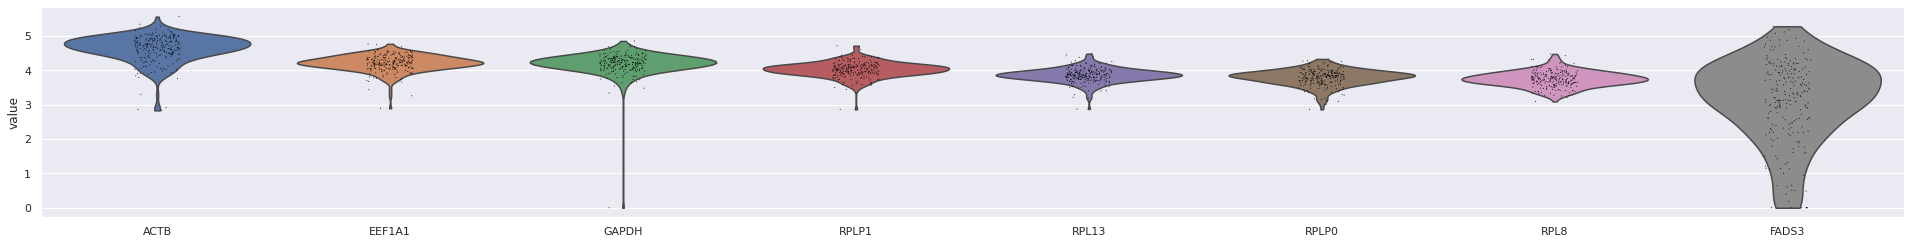

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


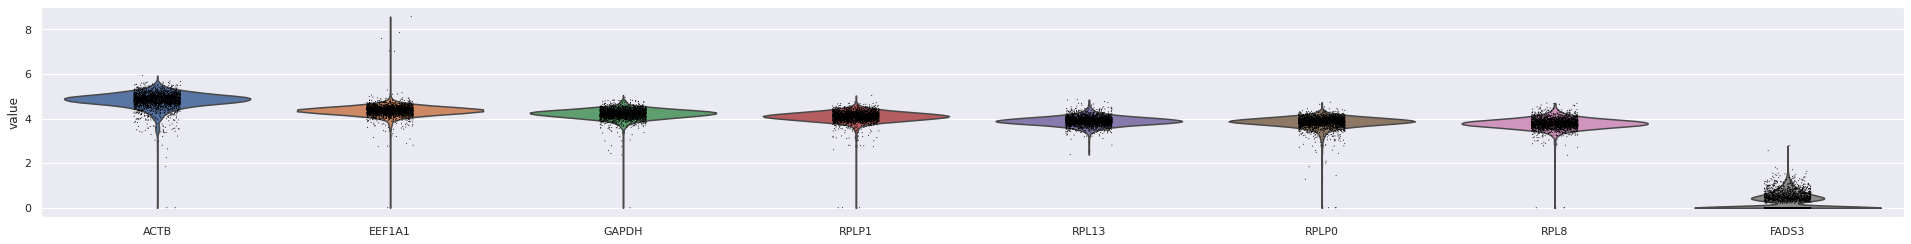

In [88]:
sc.pl.violin(adata[adata.obs["sgRNA_gene_identity"] == 'FADS3'], 
             ['ACTB','EEF1A1','GAPDH','RPLP1','RPL13','RPLP0','RPL8','FADS3'],save='FADS3_CRISPRa_endo_compare.pdf')
sc.pl.violin(adata[adata.obs["sgRNA_gene_identity"] == 'Non-Targeting'], 
             ['ACTB','EEF1A1','GAPDH','RPLP1','RPL13','RPLP0','RPL8','FADS3'],save='FADS3_control_endo_compare.pdf')

In [89]:
sub_data_CRISPRa = CRISPR_activation_data_chromHMM.loc[CRISPR_activation_data_chromHMM['Gene_name'] == "SF3B4"]
CRISPRa = sub_data_CRISPRa['value'].loc[sub_data_CRISPRa['Class'] =="CRISPRa"].to_numpy()


chromHMM 1


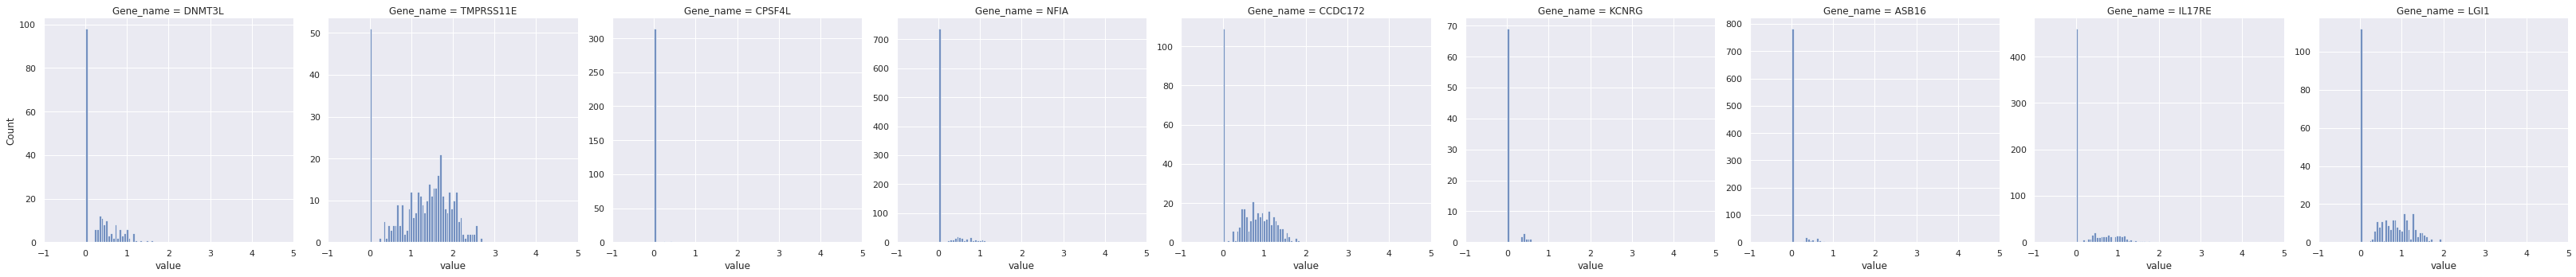

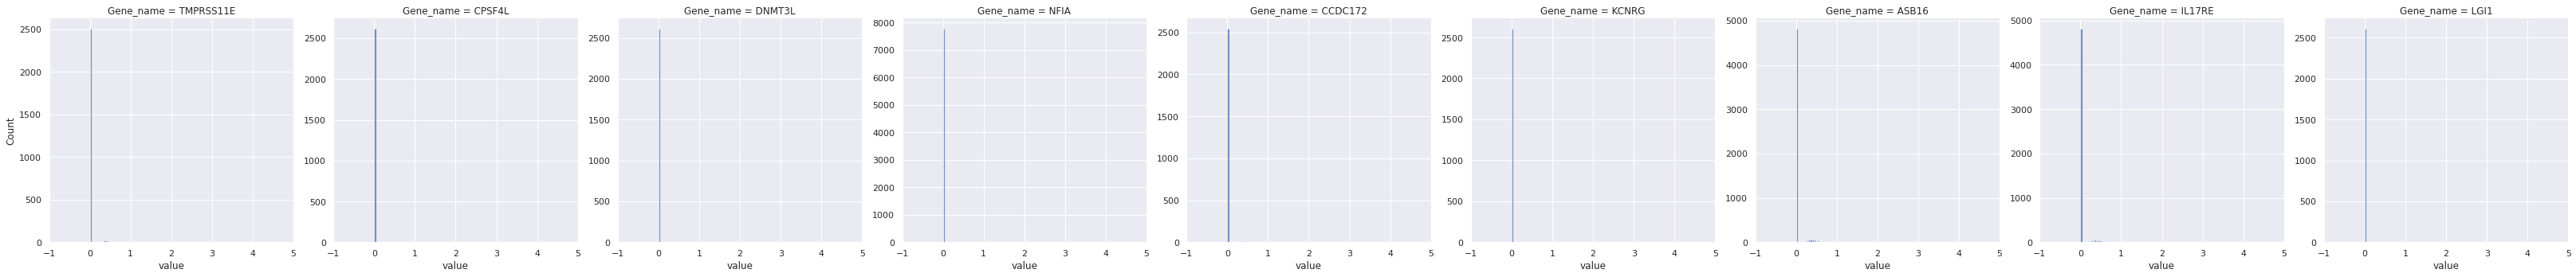

chromHMM 2


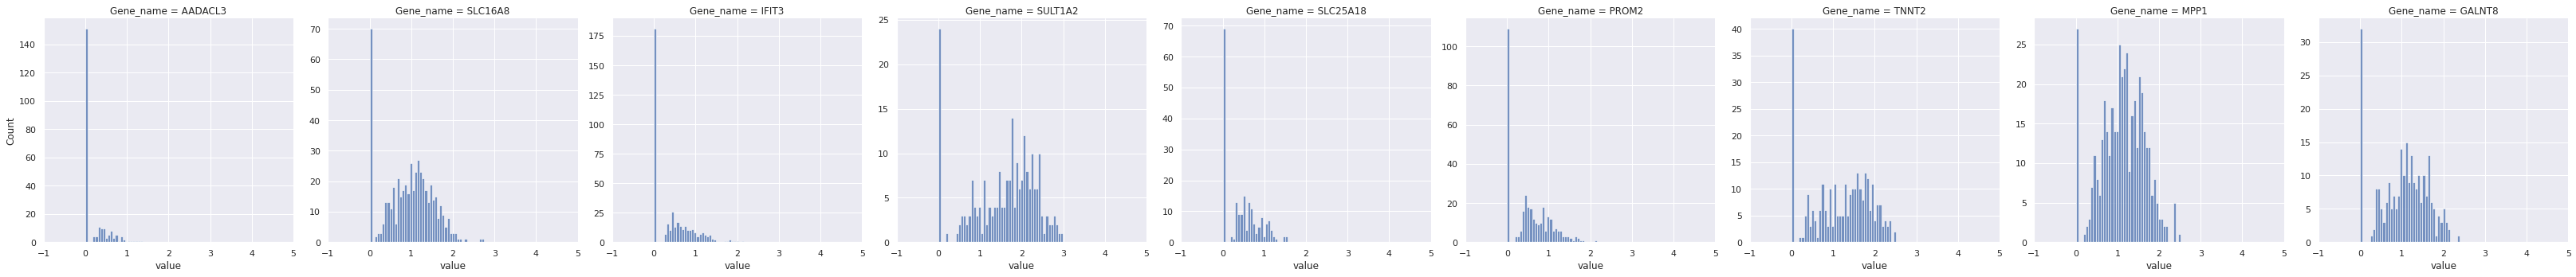

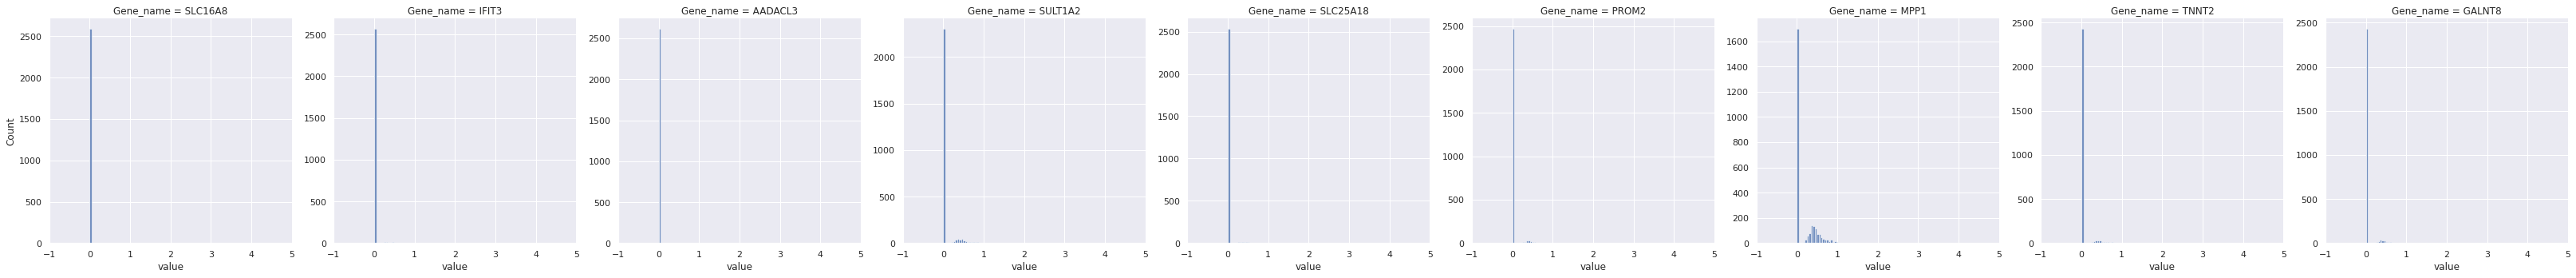

chromHMM 3


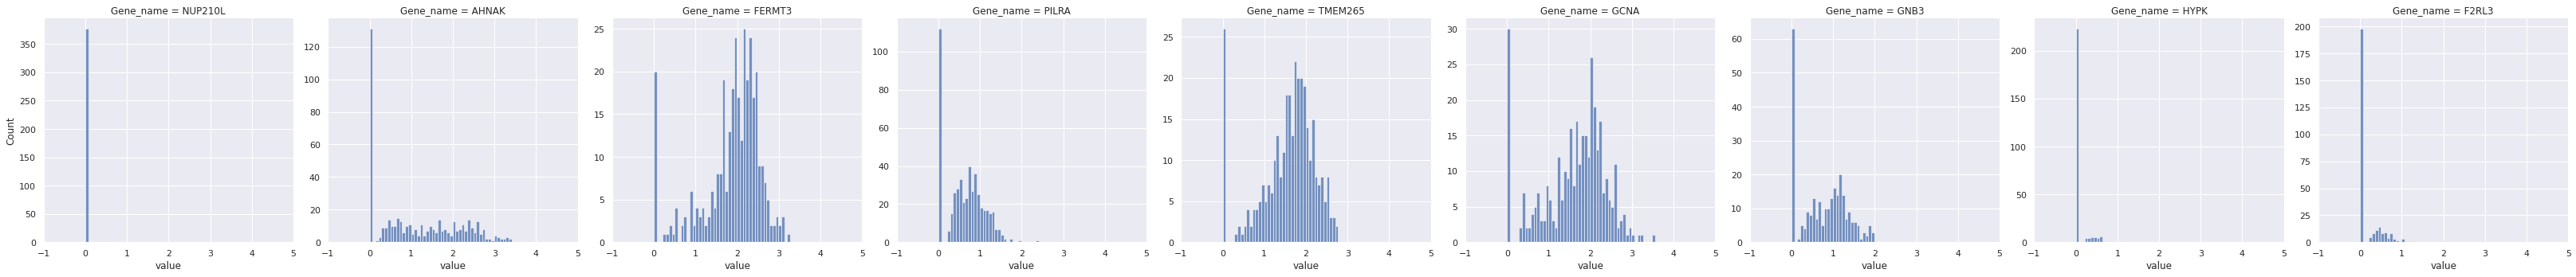

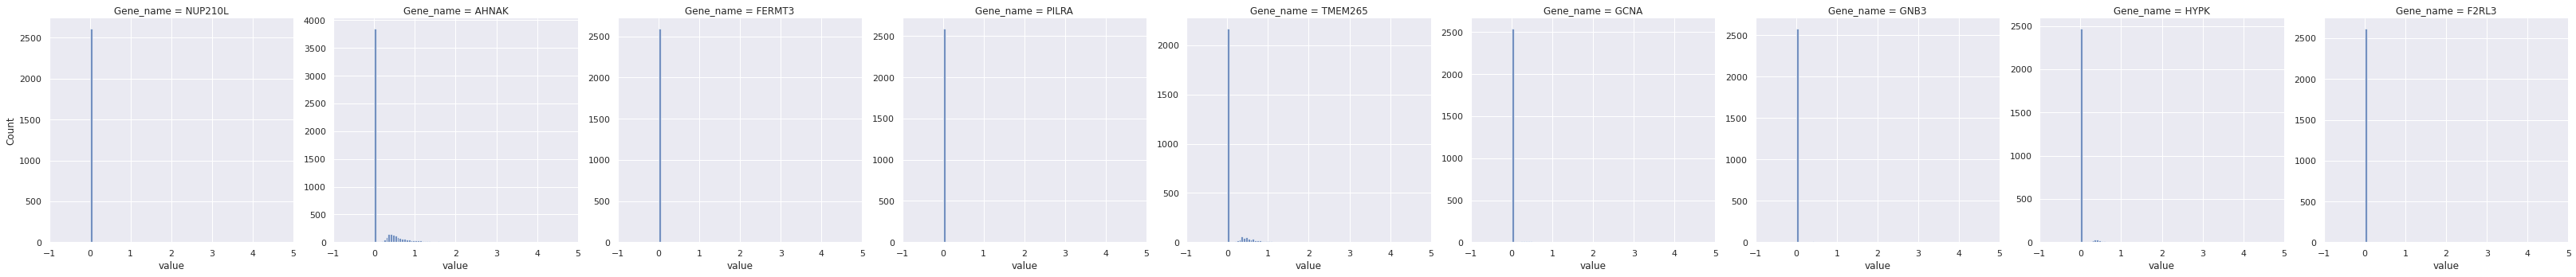

chromHMM 4


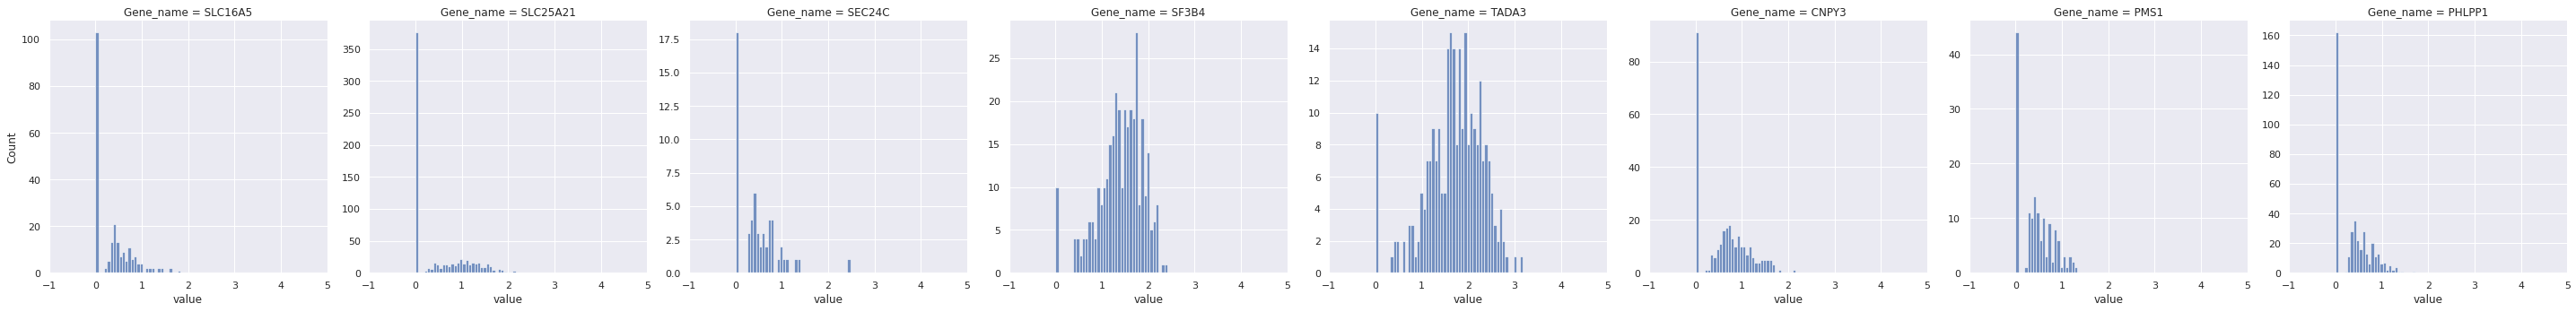

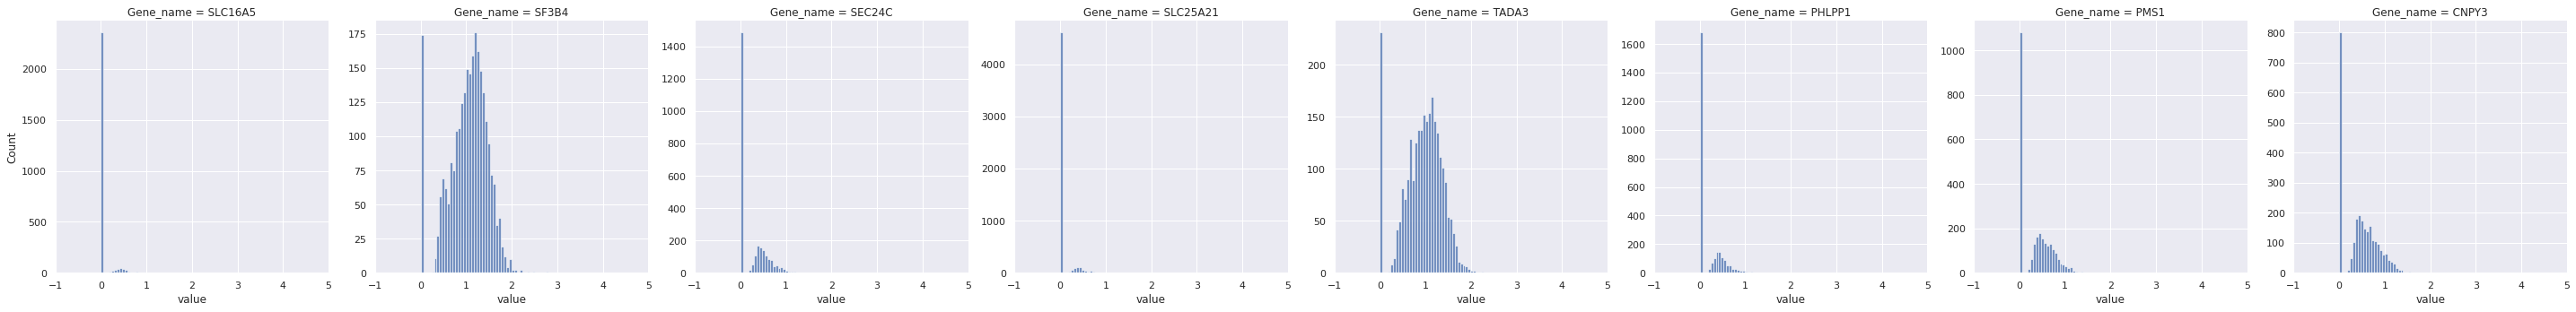

chromHMM 5


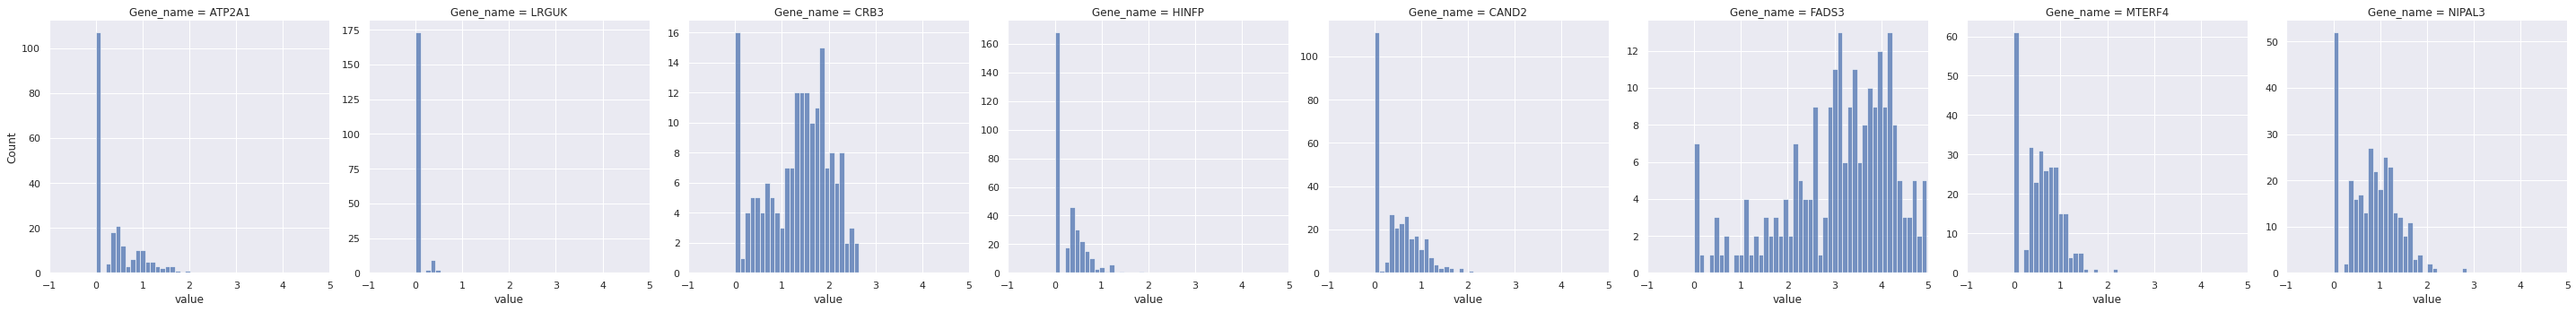

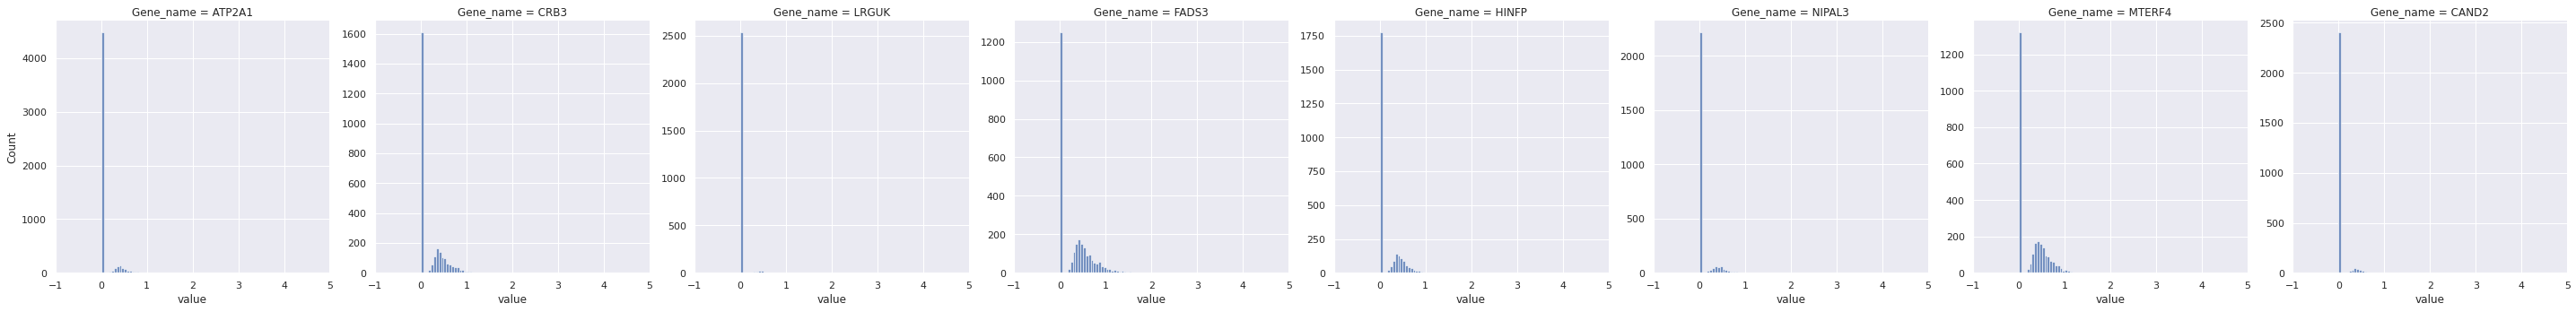

chromHMM 6


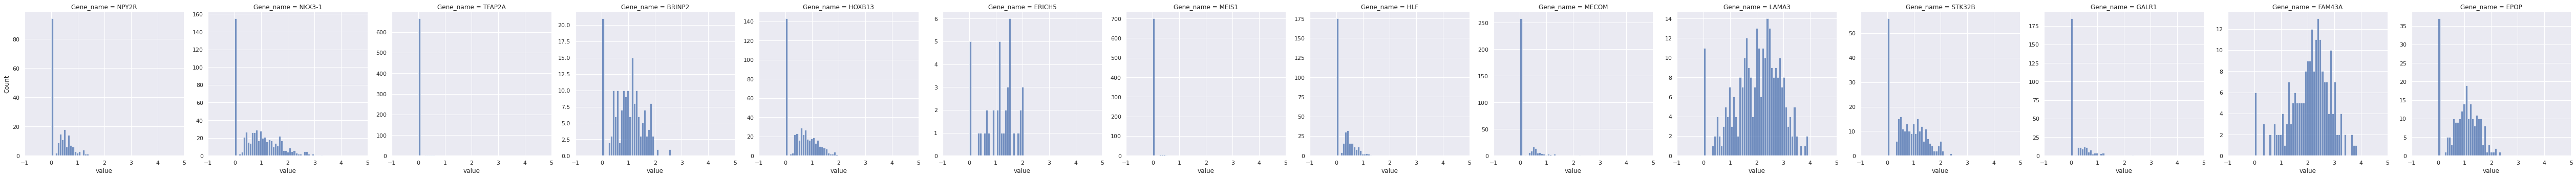

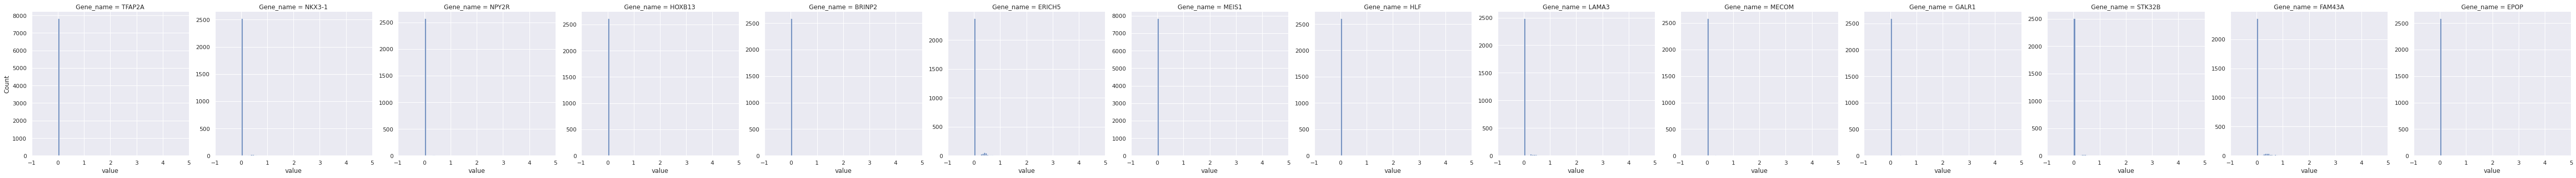

chromHMM 7


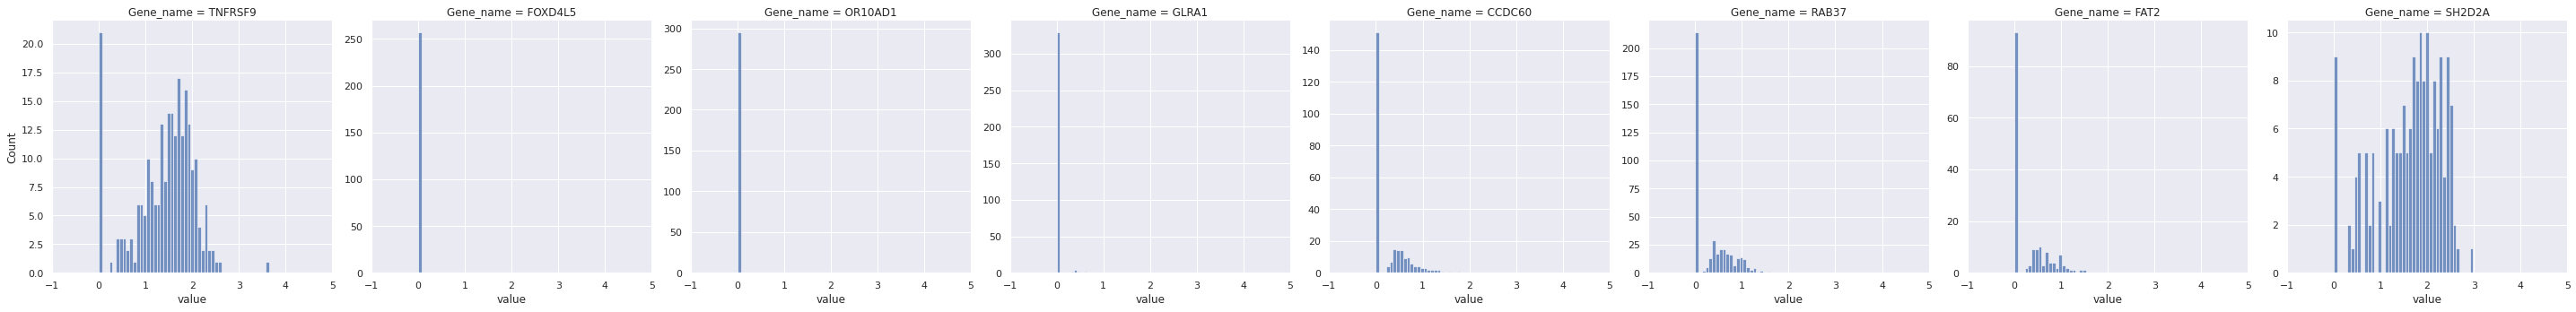

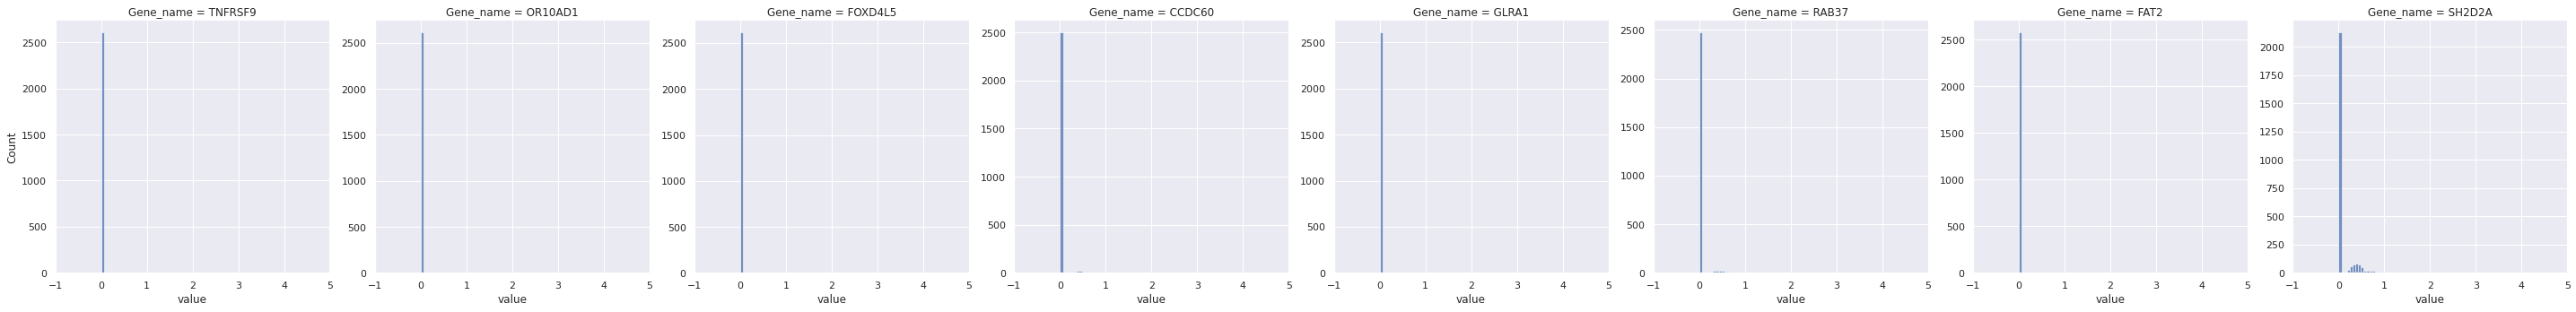

chromHMM 8


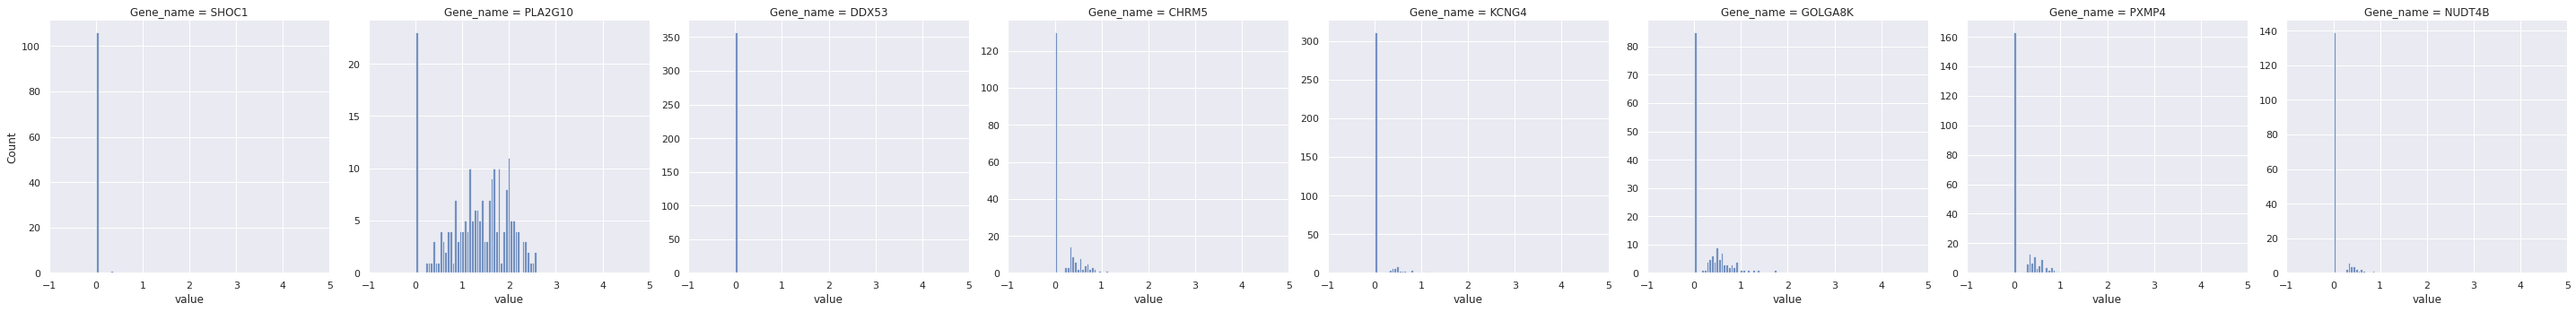

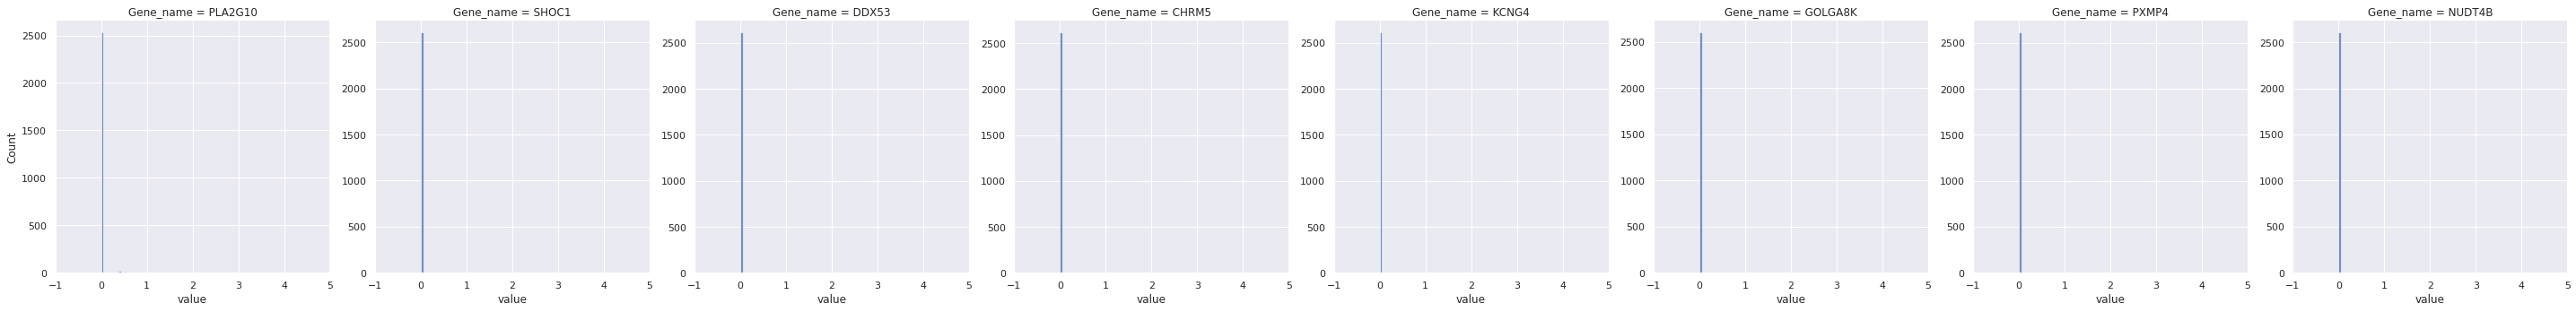

chromHMM 9


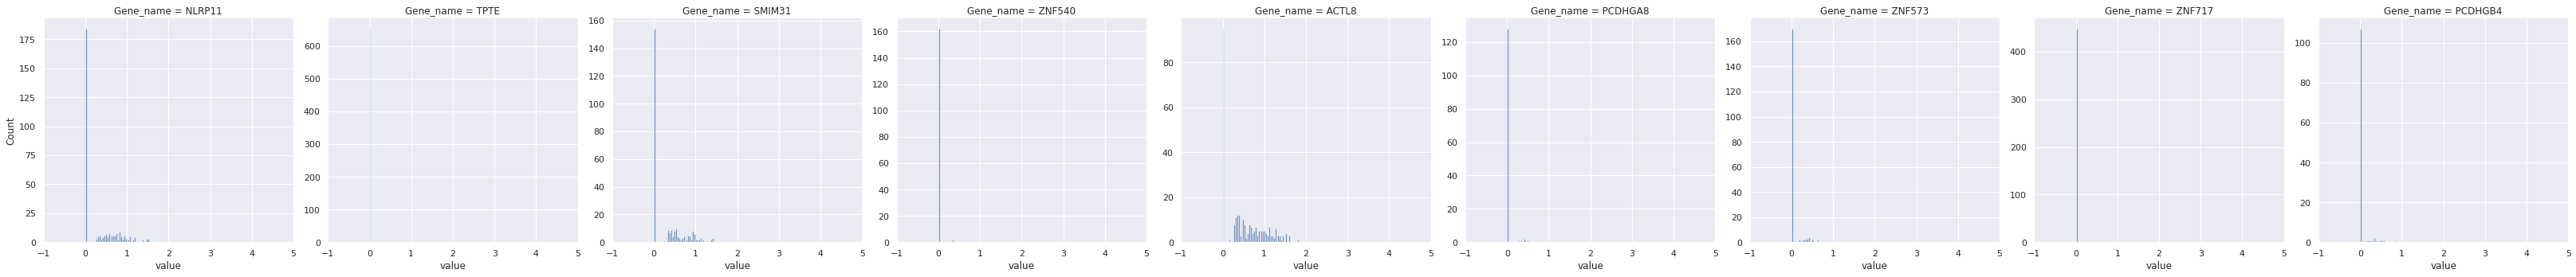

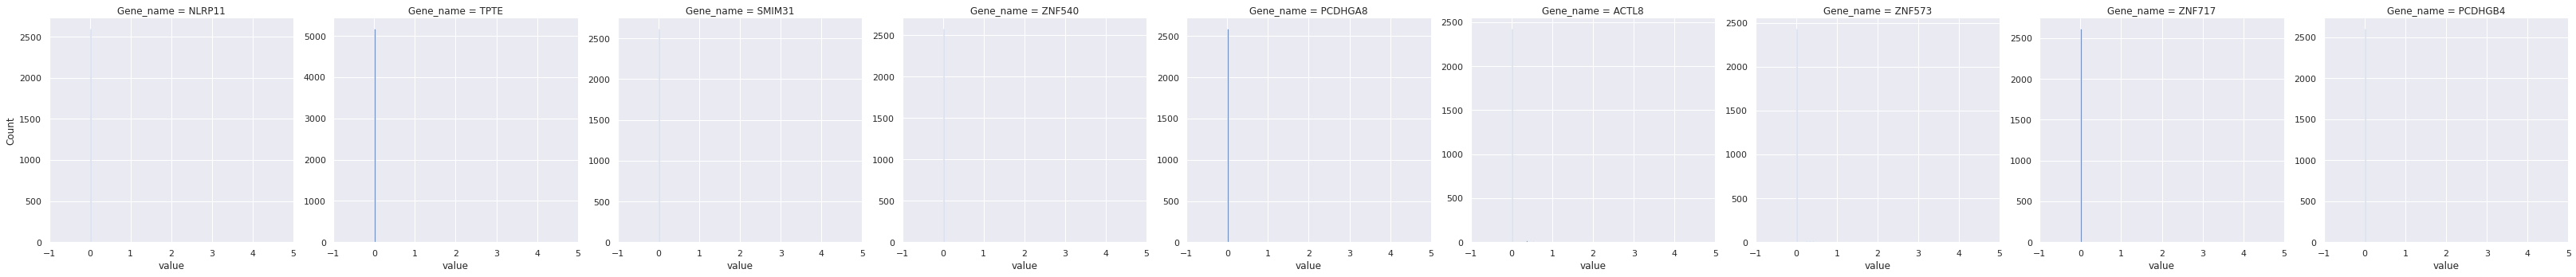

chromHMM 10


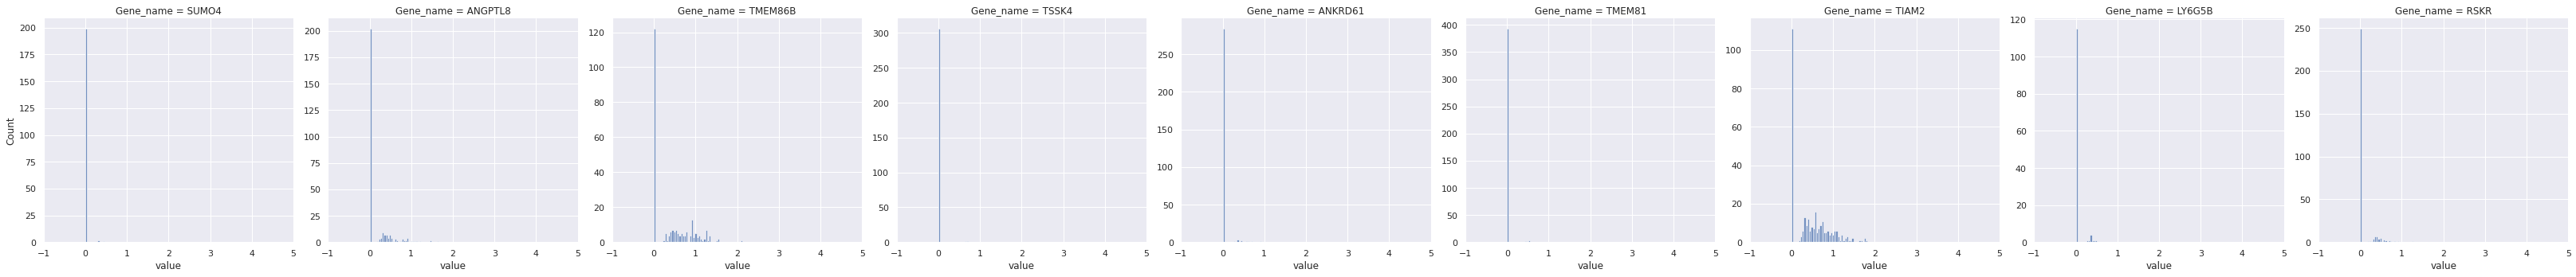

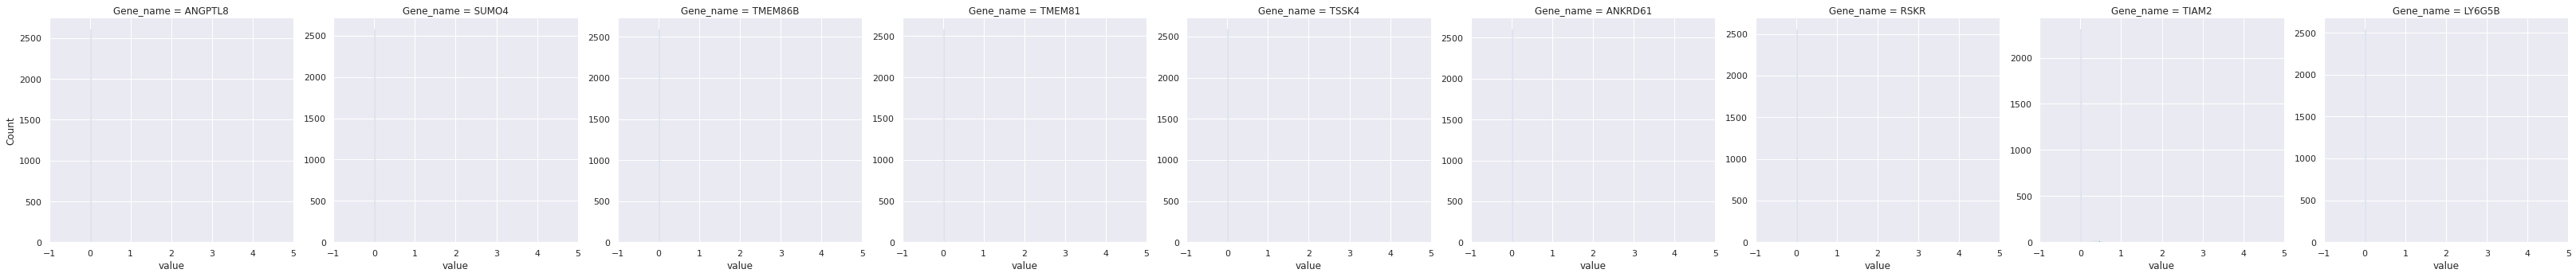

In [90]:
# generate distribution plot for each gene / class
def plot_distribution(ChromHMM, dataframe_name):
    sub_data = dataframe_name.loc[dataframe_name['ChromHMM'] == ChromHMM]
    sub_data_CRISPRa = sub_data.loc[sub_data['Class'] == "CRISPRa"]
    sub_data_control = sub_data.loc[sub_data['Class'] == "control"]
    import matplotlib.pyplot as plt
    a = sns.displot(data=sub_data_CRISPRa, kind = 'hist', bins=50, x='value', col='Gene_name', stat="count",facet_kws={'sharex': False, 'sharey': False})
    a.set(xlim=(-1, 5))
    plt.savefig('ChromHMM'+ str(ChromHMM) + 'CRISPRa_single_cell_distribution.pdf')
    b = sns.displot(data=sub_data_control, kind = 'hist', bins=50, x='value', col='Gene_name', stat="count",facet_kws={'sharex': False, 'sharey': False})
    b.set(xlim=(-1, 5))
    plt.savefig('ChromHMM'+ str(ChromHMM) + 'control_single_cell_distribution.pdf')
    plt.show()

#plot_distribution(6, CRISPR_activation_data_chromHMM)   
for i in range(1,11):
    print("chromHMM",i)
    plot_distribution(i,CRISPR_activation_data_chromHMM)
  

In [91]:
gene_chromatin.head()

Gene_name  ChromHMM  Basal_count_bulk
0     DNMT3L         1          5.000000
1     CPSF4L         1          5.333333
2  TMPRSS11E         1          5.333333
3       NFIA         1         25.666667
4      KCNRG         1         27.000000

In [92]:
# pair the data with chromHMM status and show the paired plot with group of chromHMM
gene_chromatin.head()
gene_chromatin_sub = gene_chromatin[['Gene_name','ChromHMM']].copy()
#gene_chromatin_sub = gene_chromatin_sub.rename({'sgRNA_gene_identity': 'Gene_name'}, axis='columns')
gene_chromatin_sub.head()

Gene_name  ChromHMM
0     DNMT3L         1
1     CPSF4L         1
2  TMPRSS11E         1
3       NFIA         1
4      KCNRG         1

In [93]:
CRISPR_activation_with_ChromHMM = pd.merge(CRISPR_activation_data, gene_chromatin_sub, on='Gene_name')
CRISPR_activation_with_ChromHMM = CRISPR_activation_with_ChromHMM.astype({"ChromHMM": str})
CRISPR_activation_with_ChromHMM.head()

Gene_name    Class     value  n_count        cell_barcode ChromHMM
0     ASB16  CRISPRa  0.000000  22379.0  AAAGTAGCAATACGCT-1        1
1     ASB16  CRISPRa  0.000000  22379.0  AAAGTAGCAATACGCT-1        1
2     ASB16  CRISPRa  0.000000  26002.0  AAATGCCTCTGCCAGG-1        1
3     ASB16  CRISPRa  0.325401  26002.0  AAATGCCTCTGCCAGG-1        1
4     ASB16  CRISPRa  0.000000  14895.0  AACCGCGCACCTCGGA-1        1

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

TMPRSS11E_CRISPRa v.s. TMPRSS11E_control: Welch's t-test independent samples with Bonferroni correction, P_val=4.366e-114 stat=3.391e+01
CCDC172_CRISPRa v.s. CCDC172_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.435e-78 stat=2.426e+01
ASB16_CRISPRa v.s. ASB16_control: Welch's t-test independent samples with Bonferroni correction, P_val=8.181e-02 stat=2.613e+00
CPSF4L_CRISPRa v.s. CPSF4L_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.263e+00
DNMT3L_CRISPRa v.s. DNMT3L_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.512e-23 stat=1.174e+01
IL17RE_CRISPRa v.s. IL17RE_control: Welch's t-test independent samples with Bonferroni correction, P_val=3.462e-43 stat=1.492e+01
KCNRG_CRISPRa v.s. KCNRG_control: Welch's t-test 

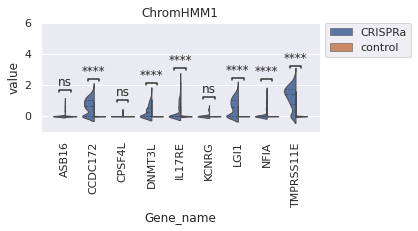

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

TNNT2_CRISPRa v.s. TNNT2_control: Welch's t-test independent samples with Bonferroni correction, P_val=3.291e-82 stat=2.768e+01
GALNT8_CRISPRa v.s. GALNT8_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.662e-76 stat=2.726e+01
AADACL3_CRISPRa v.s. AADACL3_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.883e-16 stat=9.224e+00
IFIT3_CRISPRa v.s. IFIT3_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.874e-49 stat=1.725e+01
MPP1_CRISPRa v.s. MPP1_control: Welch's t-test independent samples with Bonferroni correction, P_val=4.791e-136 stat=3.626e+01
PROM2_CRISPRa v.s. PROM2_control: Welch's t-test independent samples with Bonferroni correction, P_val=5.765e-55 stat=1.920e+01
SLC16A8_CRISPRa v.s. SLC16A8_control: Welch's t-test independen

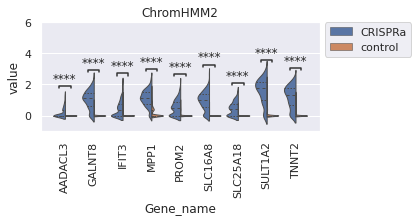

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

TMEM265_CRISPRa v.s. TMEM265_control: Welch's t-test independent samples with Bonferroni correction, P_val=7.087e-129 stat=3.947e+01
F2RL3_CRISPRa v.s. F2RL3_control: Welch's t-test independent samples with Bonferroni correction, P_val=6.337e-17 stat=9.231e+00
AHNAK_CRISPRa v.s. AHNAK_control: Welch's t-test independent samples with Bonferroni correction, P_val=8.436e-67 stat=2.058e+01
FERMT3_CRISPRa v.s. FERMT3_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.433e-154 stat=4.869e+01
GCNA_CRISPRa v.s. GCNA_control: Welch's t-test independent samples with Bonferroni correction, P_val=4.437e-126 stat=3.860e+01
GNB3_CRISPRa v.s. GNB3_control: Welch's t-test independent samples with Bonferroni correction, P_val=4.480e-63 stat=2.253e+01
HYPK_CRISPRa v.s. HYPK_control: Welch's t-test independent samp

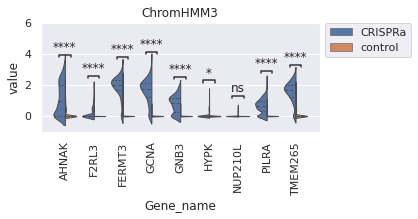

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PHLPP1_CRISPRa v.s. PHLPP1_control: Welch's t-test independent samples with Bonferroni correction, P_val=4.109e-20 stat=9.886e+00
CNPY3_CRISPRa v.s. CNPY3_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.401e-06 stat=5.233e+00
PMS1_CRISPRa v.s. PMS1_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.254e-01 stat=2.442e+00
SEC24C_CRISPRa v.s. SEC24C_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.764e-03 stat=3.807e+00
SF3B4_CRISPRa v.s. SF3B4_control: Welch's t-test independent samples with Bonferroni correction, P_val=5.151e-34 stat=1.358e+01
SLC16A5_CRISPRa v.s. SLC16A5_control: Welch's t-test independent samples with Bonferroni correction, P_val=8.868e-23 stat=1.127e+01
SLC25A21_CRISPRa v.s. SLC25A21_control: Welch's t-test indepen

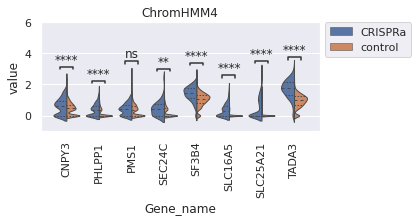

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CAND2_CRISPRa v.s. CAND2_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.284e-42 stat=1.632e+01
ATP2A1_CRISPRa v.s. ATP2A1_control: Welch's t-test independent samples with Bonferroni correction, P_val=5.875e-18 stat=9.758e+00
CRB3_CRISPRa v.s. CRB3_control: Welch's t-test independent samples with Bonferroni correction, P_val=7.754e-50 stat=2.128e+01
FADS3_CRISPRa v.s. FADS3_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.698e-97 stat=3.608e+01
HINFP_CRISPRa v.s. HINFP_control: Welch's t-test independent samples with Bonferroni correction, P_val=6.790e-08 stat=5.894e+00
LRGUK_CRISPRa v.s. LRGUK_control: Welch's t-test independent samples with Bonferroni correction, P_val=6.823e-01 stat=1.729e+00
MTERF4_CRISPRa v.s. MTERF4_control: Welch's t-test independent sampl

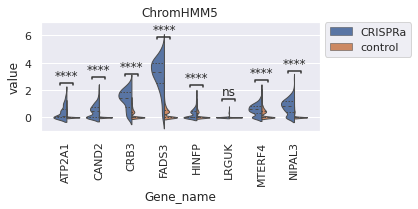

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MEIS1_CRISPRa v.s. MEIS1_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.742e-05 stat=4.796e+00
NKX3-1_CRISPRa v.s. NKX3-1_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.506e-108 stat=2.784e+01
NPY2R_CRISPRa v.s. NPY2R_control: Welch's t-test independent samples with Bonferroni correction, P_val=7.477e-24 stat=1.192e+01
STK32B_CRISPRa v.s. STK32B_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.578e-57 stat=2.134e+01
TFAP2A_CRISPRa v.s. TFAP2A_control: Welch's t-test independent samples with Bonferroni correction, P_val=3.487e-02 stat=3.035e+00
MECOM_CRISPRa v.s. MECOM_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.090e-14 stat=8.379e+00
EPOP_CRISPRa v.s. EPOP_control: Welch's t-test independent sa

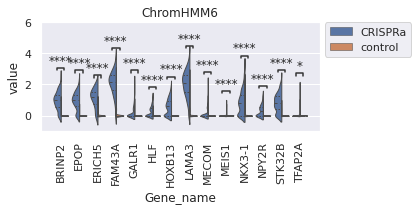

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

FAT2_CRISPRa v.s. FAT2_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.552e-16 stat=9.471e+00
CCDC60_CRISPRa v.s. CCDC60_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.531e-20 stat=1.042e+01
FOXD4L5_CRISPRa v.s. FOXD4L5_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.000e+00
GLRA1_CRISPRa v.s. GLRA1_control: Welch's t-test independent samples with Bonferroni correction, P_val=5.491e-02 stat=2.720e+00
OR10AD1_CRISPRa v.s. OR10AD1_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.364e+00
RAB37_CRISPRa v.s. RAB37_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.371e-43 stat=1.570e+01
SH2D2A_CRISPRa v.s. SH2D2A_control: Welch's t-test indepen

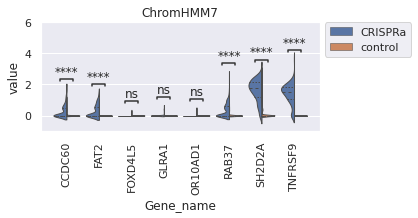

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DDX53_CRISPRa v.s. DDX53_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.234e+00
CHRM5_CRISPRa v.s. CHRM5_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.827e-15 stat=8.918e+00
GOLGA8K_CRISPRa v.s. GOLGA8K_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.190e-14 stat=8.925e+00
KCNG4_CRISPRa v.s. KCNG4_control: Welch's t-test independent samples with Bonferroni correction, P_val=5.231e-10 stat=6.736e+00
NUDT4B_CRISPRa v.s. NUDT4B_control: Welch's t-test independent samples with Bonferroni correction, P_val=3.282e-05 stat=4.769e+00
PLA2G10_CRISPRa v.s. PLA2G10_control: Welch's t-test independent samples with Bonferroni correction, P_val=9.520e-72 stat=2.765e+01
PXMP4_CRISPRa v.s. PXMP4_control: Welch's t-test independe

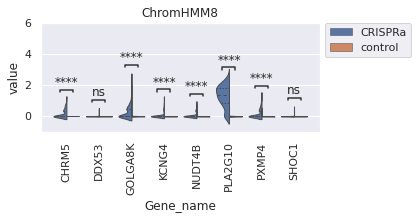

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ZNF717_CRISPRa v.s. ZNF717_control: Welch's t-test independent samples with Bonferroni correction, P_val=7.711e-01 stat=-1.719e+00
NLRP11_CRISPRa v.s. NLRP11_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.216e-30 stat=1.309e+01
ACTL8_CRISPRa v.s. ACTL8_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.184e-43 stat=1.671e+01
PCDHGA8_CRISPRa v.s. PCDHGA8_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.526e+00
PCDHGB4_CRISPRa v.s. PCDHGB4_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.504e-02 stat=3.216e+00
SMIM31_CRISPRa v.s. SMIM31_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.326e-29 stat=1.300e+01
TPTE_CRISPRa v.s. TPTE_control: Welch's t-test indepe

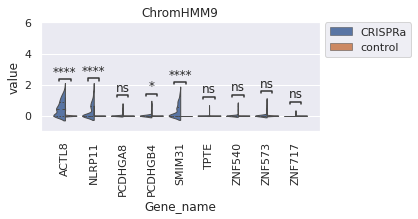

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

TSSK4_CRISPRa v.s. TSSK4_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=7.437e-01
ANKRD61_CRISPRa v.s. ANKRD61_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.714e-02 stat=3.133e+00
ANGPTL8_CRISPRa v.s. ANGPTL8_control: Welch's t-test independent samples with Bonferroni correction, P_val=3.458e-14 stat=8.335e+00
LY6G5B_CRISPRa v.s. LY6G5B_control: Welch's t-test independent samples with Bonferroni correction, P_val=7.225e-01 stat=1.763e+00
RSKR_CRISPRa v.s. RSKR_control: Welch's t-test independent samples with Bonferroni correction, P_val=2.421e-07 stat=5.713e+00
SUMO4_CRISPRa v.s. SUMO4_control: Welch's t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=5.506e-03
TIAM2_CRISPRa v.s. TIAM2_control: Welch's t-test independent

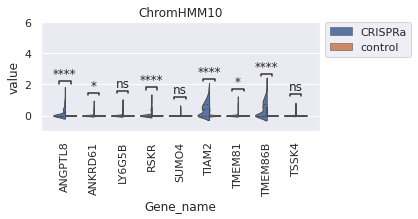

In [94]:
import seaborn as sns
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu, normaltest

sns.set_theme(style="whitegrid")

# generate the statistical pairs
my_list=["1","2","3",
        "4","5","6",
        "7","8","9","10"]
dct = {}
for i in my_list:
    dct['ChromHMM%s' % i] = []

for i in range(1,11):
    for j in CRISPR_activation_with_ChromHMM.loc[CRISPR_activation_with_ChromHMM['ChromHMM'] == str(i)]["Gene_name"].unique():
        dct['ChromHMM%s' % i].append(((j,"CRISPRa"),(j,"control")))

# genearte the seaborn paired graph with statistical annotation
for i in range(1,11):
    sns.set(rc={'figure.figsize':(5,2)})
    ax = sns.violinplot(data=CRISPR_activation_with_ChromHMM.loc[CRISPR_activation_with_ChromHMM['ChromHMM'] == str(i)],
                        x="Gene_name", y="value", hue="Class",split=True,col = "ChromHMM",
                        inner="quart", linewidth=1, scale="width")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.set_title('ChromHMM'+str(i))
    ax.set(ylim=(-1, 6))
    
    add_stat_annotation(ax, data=CRISPR_activation_with_ChromHMM.loc[CRISPR_activation_with_ChromHMM['ChromHMM'] == str(i)],
                        x="Gene_name", 
                        y="value", hue="Class", 
                        box_pairs=dct['ChromHMM%s' % i],
                        test='t-test_welch', text_format='star', loc='inside', verbose=2)
    plt.savefig('ChromHMM'+ str(i) + '_individual_gene.pdf')
    plt.show()

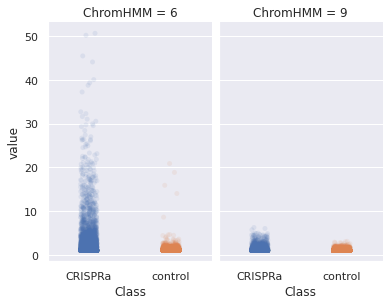

In [95]:
CRISPR_activation_with_ChromHMM_bivalent_silence = CRISPR_activation_with_ChromHMM.loc[CRISPR_activation_with_ChromHMM['ChromHMM'].isin(["6","9"])]

# Draw a nested violinplot and split the violins for easier comparison
g = sns.catplot(data=CRISPR_activation_with_ChromHMM_bivalent_silence, 
            x="Class", 
            y= np.exp(CRISPR_activation_with_ChromHMM_bivalent_silence['value'].astype(float)),
            hue="Class",col="ChromHMM",alpha=.1)

g.fig.set_size_inches(5,4)

#plt.savefig('Bivalent_vs_ZNF.pdf')